<b>Data mining Project - 2020/21</b><br/>
<span>
<b>Authors:</b> <a href="#">Diletta Goglia</a> and <a href="#">Marco Petix</a><br/>
<b>Python version:</b>  3.x<br/>
<b>Last update:</b> 29/11/2020
</span>

# Task 2: Data Clustering

## Introduction and Dataset Description

This notebook contains a clustering analysis on the "customers" dataset. 
Said dataset has been derived from the dataset "customer_supermarket" by gathering the informations regarding each individual customer and computing new indicators of their shopping behaviour.

The "customers" dataset is initially presented as split into two different dataframes: "customers_num", dedicated to the numerical attributes involved with the clustering process, and "customers_cat", dedicated to some additional attributes, both categorical and numeric, involved in the characterization of the clusters.

The whole dataset contains 3646 observations, each one describing the behaviour of a single customer.

**Importing libraries**

In [1]:
%matplotlib inline
import math
from math import pi

import numpy as np
import pandas as pd
import collections

import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sn

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score 

from yellowbrick.cluster import KElbowVisualizer
#from yellowbrick.cluster import InterclusterDistance

C:\Users\markp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


**Loading the dataset**

We read the .csv files containing the two sub-datasets.

In [2]:
cs_num = pd.read_csv('dataset/customers_num.csv', index_col=0)
cs_cat =  pd.read_csv('dataset/customers_cat.csv', index_col=0)

## Elimination of highly correlated features

We begin by examining the correlations between the attributes of the dataset to be clustered in order to identify the highly correlated couples. 
Dropping redundant attributes benefits the analysis by reducing the dimensionality of the dataset and rising the influence that more useful feature could have on the whole clustering process.  

With such aim in mind, we fix a maximum **threshold** value in order to identify highly correlated features and subsequently drop them.

In [3]:
corr_threshold = 0.9
print("Att. A\tAtt. B\tCorr(A,B)")
for i in range(0, len(cs_num.columns)):
    for j in range(i+1, len(cs_num.columns)):
        corr = cs_num[cs_num.columns[i]].corr(cs_num[cs_num.columns[j]])
        if  corr > corr_threshold:
            print(cs_num.columns[i] + "\t" + cs_num.columns[j] + "\t" + '{:.4f}'.format(corr))

Att. A	Att. B	Corr(A,B)
I	Stot	0.9362
Iu	NSess	0.9684
Eb	Ew	0.9198
Eb	Em	0.9658
Ew	Em	0.9114
Smax	SWmax	0.9791
Smax	SMmax	0.9229
Savg	SWavg	0.9700
Savg	SMavg	0.9265
SWmax	SMmax	0.9446
SWavg	SMavg	0.9596


As a result of this analysis we decide to eliminate many of the attributes derived from customer spending (SWmax, SWavg, SMmax, SMavg) and some entropy indicators (Em, Ew).

Despite the high correlation between the *Stot* and *I* attributes we decide not to eliminate either of them due to their relevance within the whole grouping process. This choice was suggested by the tests mentioned above and will be confirmed in the rest of the notebook.

In [4]:
cs_corr_columns = ['Iavg', 'Ew', 'Em', 'Ir', 'Sref', 'SWmax', 'SWavg', 'SMmax', 'SMavg']
cs_num.drop(cs_corr_columns, axis=1, inplace=True)
cs = cs_num

This is the current arrangement of the dataset.

In [5]:
cs.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3643 entries, 13047.0 to 12713.0
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   I       3643 non-null   int64  
 1   Iu      3643 non-null   int64  
 2   Imax    3643 non-null   int64  
 3   Ep      3643 non-null   float64
 4   Eb      3643 non-null   float64
 5   Stot    3643 non-null   float64
 6   Smax    3643 non-null   float64
 7   Savg    3643 non-null   float64
 8   NSess   3643 non-null   int64  
dtypes: float64(5), int64(4)
memory usage: 284.6 KB


## Normalization
The most common adopted normalizations are: Z-Score and Min-Max.
- The Min-Max normalization approach instead allows to have data that are alwayse interpretable, so that we can avoid to apply inverse transformation.
- The Z-Score normalization approach exploits the mean and standard deviation of data, and tries to center data with respect to these two statistical properties.

In the coming analysis we choose to use the Min-Max normalization in order to have a leaner approach and avoid an unnecessary inverse transformation.

### Min-Max Normalization

In [6]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
cs_norm_minmax = minmax_scaler.fit_transform(cs.values)

### Extra: Z-Score Normalization

In [7]:
# from sklearn.preprocessing import StandardScaler
# z_scaler = StandardScaler()
# cs_norm_z = z_scaler.fit_transform(cs_no_out.values)

# Clustering Analysis by K-means

## Identification of the best value of k 
The value of *k* is the main parameter of the algorithm and represents the number of clusters that we want to split the dataset into. There are several techniques to identify the optimal value of said parameter. Ultimately our aim in this context is to run multiple executions of the algorithm, each with a different value for *k*, and then performing an evaluation analysis.

### Elbow Method on the clusters Inertia
In cluster analysis, the elbow method is a heuristic used in determining the optimal number of clusters in a data set. 
<br>It consists of plotting the SSE as a function of the number of clusters, and **picking the elbow** of the curve as the *k* to use.

We start from an initial value of 2 and we keep computing the clusterization until we reach the value of 30, our choice for the maximum value of *k*. 
<br>Considering ranges of k differing in size may lead to slightly different elbows, so we also plot the curves of the intervals [2,10] and [2,20].

#### For k = [2, 10], [2, 20] and [2,30]

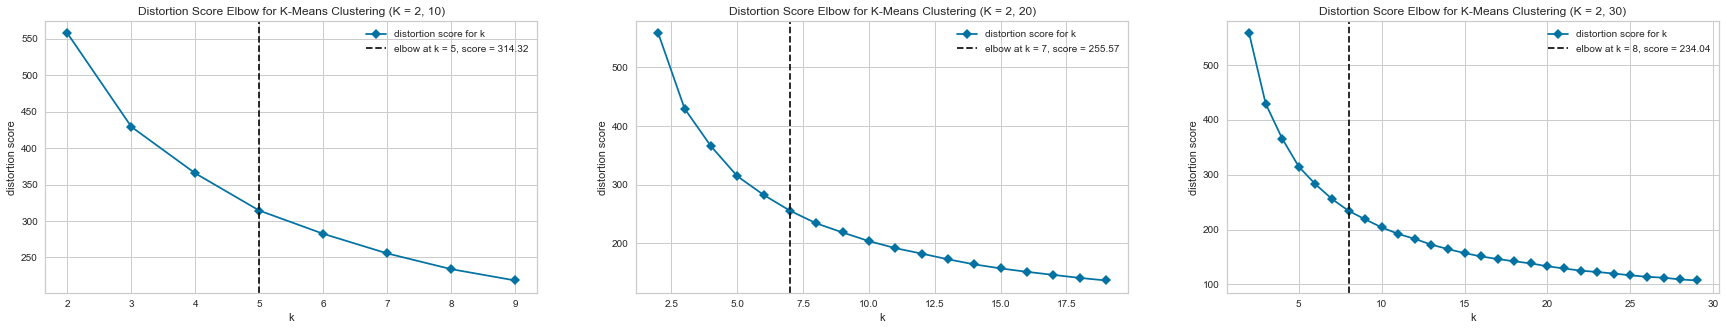

In [8]:
k_start = [2]
k_max = [10, 20, 30]
Ks = []
model = KMeans()

# print the elbow plots
f, axs = plt.subplots(nrows=1, ncols=len(k_max), figsize=(30,5))

for i in range(len(k_max)):
    vis = KElbowVisualizer(model, k=(k_start[0],k_max[i]), metric='distortion', timings=False, ax=axs[i])
    vis.fit(cs_norm_minmax)  
    axs[i].set_title('Distortion Score Elbow for K-Means Clustering (K = ' + str(k_start[0]) + ', ' + str(k_max[i]) + ')' )
    axs[i].set_ylabel('distortion score')
    axs[i].set_xlabel('k')
    axs[i].legend(['distortion score for k','elbow at k = ' + str(vis.elbow_value_) + ', score = ' + '{:.2f}'.format(vis.elbow_score_)])
    if (vis.elbow_value_ not in Ks) and (vis.elbow_value_ != None):
        Ks.append(vis.elbow_value_)
plt.show()

#### Extra: Starting by k = 1

In order to experiment with different intervals, we repeat the above analysis starting from a value of k equal to 1, representing the presence of a single large cluster and therefore the absence of the clustering process.

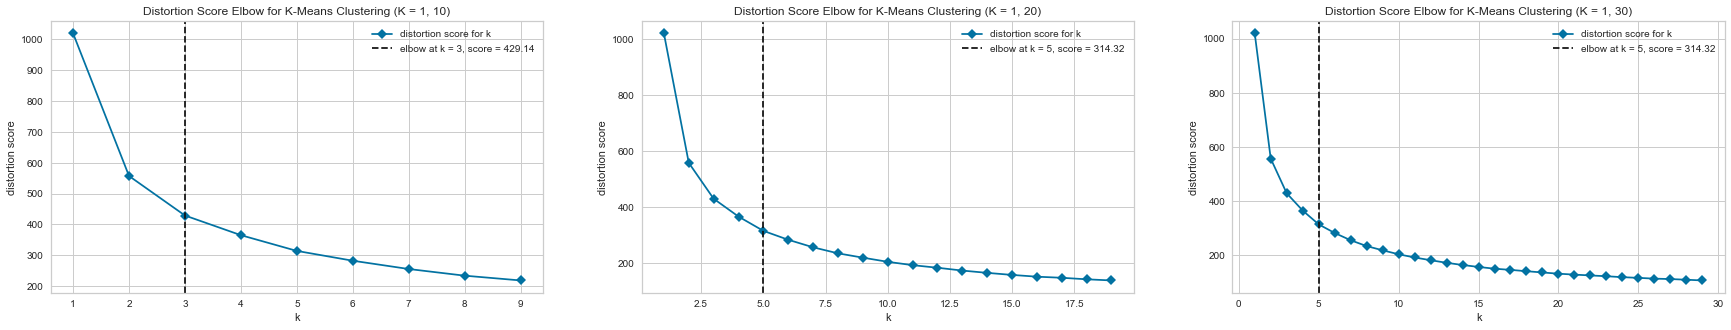

In [9]:
k_start = [1]
k_max = [10, 20, 30]
model = KMeans()

# print the elbow plots
f, axs = plt.subplots(nrows=1, ncols=len(k_max), figsize=(30,5))

for i in range(len(k_max)):
    vis = KElbowVisualizer(model, k=(k_start[0],k_max[i]), metric='distortion', timings=False, ax=axs[i])
    vis.fit(cs_norm_minmax)  
    axs[i].set_title('Distortion Score Elbow for K-Means Clustering (K = ' + str(k_start[0]) + ', ' + str(k_max[i]) + ')' )
    axs[i].set_ylabel('distortion score')
    axs[i].set_xlabel('k')
    axs[i].legend(['distortion score for k','elbow at k = ' + str(vis.elbow_value_) + ', score = ' + '{:.2f}'.format(vis.elbow_score_)])
    if (vis.elbow_value_ not in Ks) and (vis.elbow_value_ != None):
        Ks.append(vis.elbow_value_)
plt.show()

### Average Silhouette Method
The silhouette score is a indicator of both separation and cohesion among clusters. Here we look for the clusterization with the highest average silhouette score among those computed by K-means.

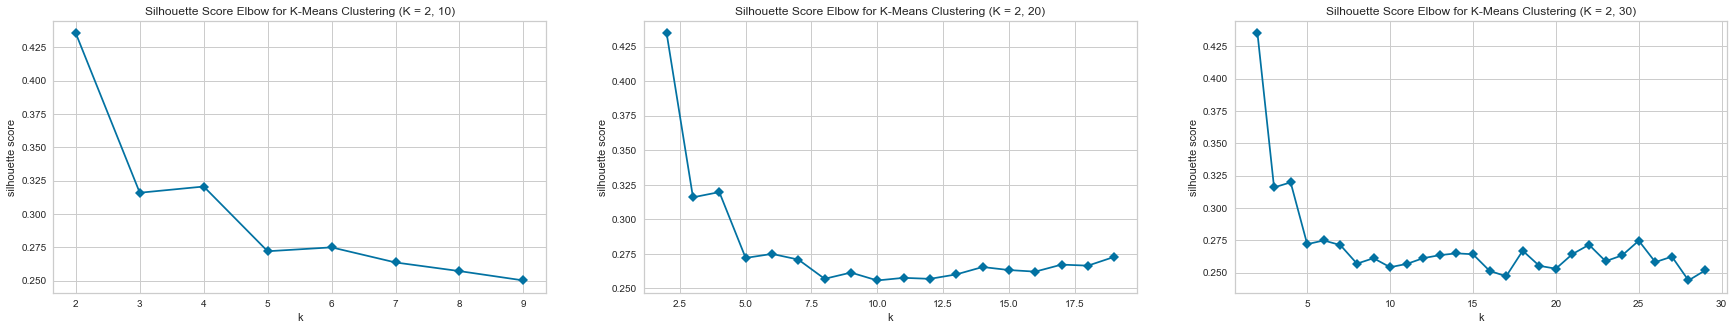

In [10]:
k_start = [2]
k_max = [10, 20, 30]
model = KMeans()

# print the elbow plots
f, axs = plt.subplots(nrows=1, ncols=len(k_max), figsize=(30,5))

for i in range(len(k_max)):
    vis = KElbowVisualizer(model, k=(k_start[0],k_max[i]), metric='silhouette', timings=False, ax=axs[i], locate_elbow=False)
    vis.fit(cs_norm_minmax)  
    axs[i].set_title('Silhouette Score Elbow for K-Means Clustering (K = ' + str(k_start[0]) + ', ' + str(k_max[i]) + ')' )
    axs[i].set_ylabel('silhouette score')
    axs[i].set_xlabel('k')
plt.show()

An analysis of the average Silhouette score highlights a global maxima for k equals to 2 and a local maxima for k equals to 4.

In [11]:
k_from_sil = [2,4]

We add these values to the list of candidates for the optimal value of k. 

In [12]:
for k in k_from_sil:
    if k not in Ks:
        Ks = np.append(Ks, k_from_sil)

### Insights from Hierarchical Clustering
Here we try to identify the optimal number of clusters by analysing the hierarchical clustering performed throught the Ward method. <br>Said method aims at the local optimization of the SSE fuction and therefore it is often used in conjunction with K-means.

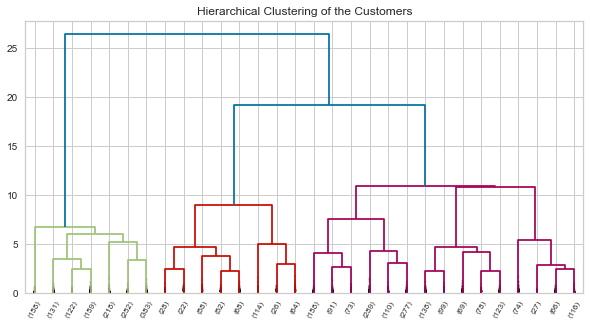

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(10, 5))
plt.title("Hierarchical Clustering of the Customers")
plt.axhline(y=80, ls='--', c='red')
dend = dendrogram(linkage(cs_norm_minmax, method='ward'), truncate_mode='lastp', p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True)

The clustering obtained throught the Ward linkage seems to suggest the presence of three main clusters within the dataset.

In [14]:
k_from_ward = 3

We add this value to the aforementioned list of candidates. 

In [15]:
if k_from_ward not in Ks:
    Ks = np.append(Ks, k_from_ward)

We proceed by sorting the list of candidates and perform the clustering for each of these values.

In [16]:
Ks = np.sort(Ks)
Ks

array([2, 3, 4, 5, 7, 8])

### Clustering by K-means for each of the candidates

We perform the clustering for the values of *k* previously picked.
<br>For each *k* we store the information regarding the centroids, the SSE values associated with the clustering and, most importantly, the labels associating each record to its cluster.

In [17]:
cs_centers = []
cs_labels = []
cs_inertia = []
for k in Ks:
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100) 
    kmeans.fit(cs_norm_minmax) # we perform the clustering for each value of k
    cs_centers.append(minmax_scaler.inverse_transform(kmeans.cluster_centers_)) # we store the coordinates of the centroids
    cs_labels.append(kmeans.labels_) # we store the labels associated with the records
    cs_inertia.append(kmeans.inertia_) # we store the SSE value associated with the clustering

### Comparison and evaluation of the different clustering via internal metrics

Each clustering is now evalueated with respect to well known measures of the clusters cohesion and separation. 
The aim of this process is to identify the value of k resulting in the best defined clusters. 

The (internal) evaluation metrics that we are going to compute are:
* **Sum of Squared Error (SSE)** 
* **Davies Bouldin Index** 
* **Silhouette Score** 
* **Calinski-Harabasz Index**, also called Variance Ratio Criterion

In [18]:
int_metrics_K=pd.DataFrame() # we create a dataframe to contain the results of the evaluation

k_cols = []
for k in Ks:
    k_cols.append('K_' + str(k))
    
sse=[]
sep=[]
sil=[]
cal_har=[]

# wrt categorical features
for i in range(len(Ks)):
    sse.append(cs_inertia[i])
    sep.append(davies_bouldin_score(cs_norm_minmax, cs_labels[i]))
    sil.append(silhouette_score(cs_norm_minmax, cs_labels[i]))
    cal_har.append(calinski_harabasz_score(cs_norm_minmax, cs_labels[i]))

int_metrics_K['K'] = k_cols
int_metrics_K['SSE'] = sse
int_metrics_K['Davies_Bouldini'] = sep
int_metrics_K['Silhouette'] = sil
int_metrics_K['Calinski_Harabasz'] = cal_har
int_metrics_K.set_index(['K'], inplace=True)
int_metrics_K

SSE  Davies_Bouldini  Silhouette  Calinski_Harabasz
K                                                              
K_2  557.294186         1.002153    0.435007        3021.802248
K_3  429.136133         1.160057    0.315443        2505.103841
K_4  365.354942         1.192858    0.321506        2172.847202
K_5  314.321795         1.147942    0.272066        2041.370447
K_7  255.594937         1.183484    0.270354        1811.916029
K_8  234.040123         1.127170    0.257634        1743.472511

Regarding the **Sum of Squared Errors (SSE)**:
- a decrease in the SSE value proportional to the number of clusters is an expected behavior, therefore opting directly for the clustering with the lowest sum of squared distances may not be a worthwhile decision.

Regarding the **Davies Bouldini Index**: 
- a lower Davies-Bouldin index relates to a model with better separation between the clusters and, in this regard, the clustering with **k equals to 2 seems to present the best separation among its clusters**.

Regarding the **Silhouette Score**: 
- a higher value for the Silhouette Coefficient relates to a model with better defined clusters, in this regard, the clustering with **k equals to 2 presents the best score**.

Regarding the **Calinski-Harabasz Index**: 
- similarly to the Silhouette Coefficient, a higher value for the Calinski-Harabasz score relates to a model with better defined clusters, in this regard, the clustering with **k equals to 2 seems to present the best defined clusters**.

### Conclusions

As mentioned previously, a low SSE is not an absolute indicator of good clustering. The purpose of the elbow method is precisely to identify particular values of k for which the decrease in this error is significant even with respect to the normal decrease due to the increase in the number of clusters.

Given the promising results on all of the others evaluation metrics **we consider two as the optimal number of clusters for the dataset under analysis**.

In [19]:
opt_k = 2
opt_k_index = np.where(Ks == opt_k)[0].item() # we identify the index of the optimal value of k among the other k candidates

In [20]:
opt_k_index

0

### Extra: Setup operations

We define a function to improve the data visualization via bar plots.

In [21]:
def autolabel(rects, i = None, j = None):
    if (i != None) and (j!=None): 
        target = axs[i][j]
    elif i != None:
        target = axs[i]
    else:
        target = axs    
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        target.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

We extract the list of centroids and labels referring to the clustering for the optimal value of k.

In [22]:
k = Ks[opt_k_index] # it contains the optimal value of k
centers = cs_centers[opt_k_index] # it contains the centroids for the optimal value of k
labels = cs_labels[opt_k_index] # # it contains the labels for the optimal value of k

In order to analyze the dataset population as divided between the different clusters, we add the categorical attributes and the labels obtained through the optimal clustering to the main dataframe.

In [23]:
cs = cs.join(cs_cat)
cluster_col = 'K_' + str(k) # it contains the name of the column containing the optimal labels
cs[cluster_col] = labels

This is the current shape of the main dataframe.

In [24]:
cs.head()

I   Iu  Imax        Ep        Eb     Stot    Smax        Savg  \
CustomerID                                                                     
13047.0     1296   89   301  6.251688  2.883182  2614.81  449.70  290.534444   
14688.0     2312  133   251  6.718327  4.047886  3394.39  402.50  178.652105   
17809.0      305   27   204  4.754888  1.576066   729.45  560.40  182.362500   
16098.0      435   24   112  4.305245  2.728077  1107.51  293.14  158.215714   
18074.0       52    8    52  3.000000  0.000000   185.30  185.30  185.300000   

            NSess         Country Fav_weekday Fav_month  K_2  
CustomerID                                                    
13047.0       146  United Kingdom      Friday     April    1  
14688.0       264  United Kingdom      Friday     April    1  
17809.0        27  United Kingdom      Friday  February    0  
16098.0        54  United Kingdom      Monday     April    0  
18074.0         8  United Kingdom     Tuesday   January    0

We also build a dataframe with the labels obtained from all the previous clusterings. It is going to be used in a later analysis and comparison with the other kind of clustering.

In [25]:
cs_clusters = cs.drop(columns=cs.columns)
for i in range(len(Ks)):
    cs_clusters['K_' + str(Ks[i])] = cs_labels[i]

## Characterization of the clusters for K = 2
We now begin an analysis aimed at studying the composition and population of the clusters, in order to fully understand and interpret the results provided by the k-means algorithm.

### Silhouette Analysis

Here we analyze the shape and size of the clusters.

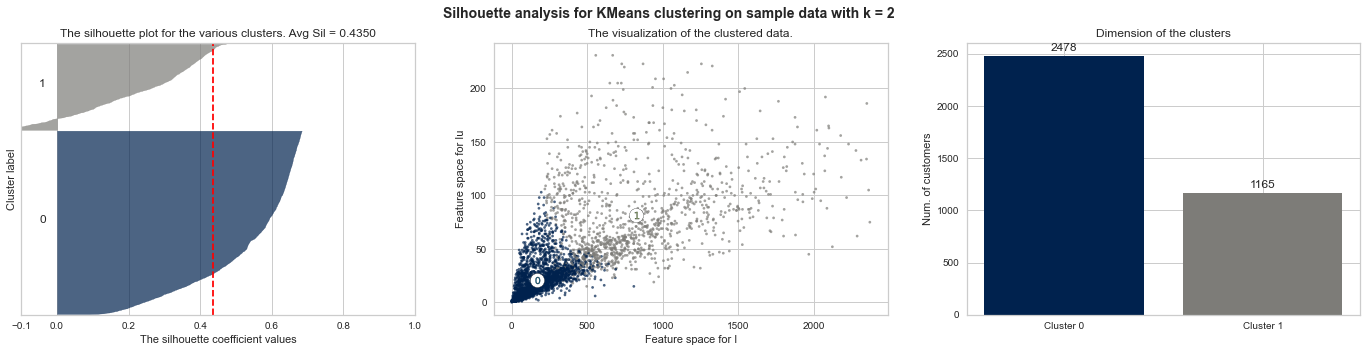

In [26]:
# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(24, 5)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
axs[0].set_xlim([-0.1, 1])
# The (k+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
axs[0].set_ylim([0, len(cs_norm_minmax) + (k + 1) * 10])

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(cs_norm_minmax, labels)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(cs_norm_minmax, labels)
bar_colors = []
y_lower = 10
for i in range(k):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.cividis(float(i) / k)
    bar_colors.append(color)
    axs[0].fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    axs[0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

axs[0].set_title("The silhouette plot for the various clusters. Avg Sil = " + '{:.4f}'.format(silhouette_avg))
axs[0].set_xlabel("The silhouette coefficient values")
axs[0].set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
axs[0].axvline(x=silhouette_avg, color="red", linestyle="--")

axs[0].set_yticks([])  # Clear the yaxis labels / ticks
axs[0].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.cividis(labels.astype(float) / k)
axs[1].scatter(cs[cs.columns[0]], cs[cs.columns[1]], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

# Draw white circles at cluster centers
axs[1].scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    axs[1].scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

axs[1].set_title("The visualization of the clustered data.")
axs[1].set_xlabel("Feature space for " + cs.columns[0])
axs[1].set_ylabel("Feature space for " + cs.columns[1])

hist, bins = np.histogram(labels, bins=range(0, len(set(labels)) + 1))
autolabel(axs[2].bar(list(range(0,len(set(labels)))), hist, color=bar_colors, tick_label=['Cluster 0', 'Cluster 1']), 2)
axs[2].set_title('Dimension of the clusters')
axs[2].set_ylabel('Num. of customers')

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              "with k = %d" % k), fontsize=14, fontweight='bold')
plt.show()

Insights from the **Silhouette Plot**:
- the red dotted line identifies the average silhouette score among the whole clustering
    - most of the points from cluster 0 present a higher than average silhouette     
    - almost every point from cluster 1 possess a lower than average silhouette
- some points from cluster 1 even present negative silhouette scores and this is ususally a clue for these points being outliers

Insights from the **scatter** and **bar plot**:
- the points within cluster 1 are fewer and more sparse than those within cluster 0

#### Extra: Identifying the outliers within cluster 1

We proceed by computing an ad hoc color array to use in order to highlight the outliers contained within cluster 1.

In [27]:
negative_sil = silhouette_samples(cs_norm_minmax, labels)
negative_sil_colors = []
for i in range(len(negative_sil)):
    if negative_sil[i] < 0:
        negative_sil_colors.append('r')
    elif labels[i] == 0:
        negative_sil_colors.append('#00224e')
    else:
        negative_sil_colors.append('#7d7c78')

This is the scatter plot highlighting, in red, the aforementioned outliers.

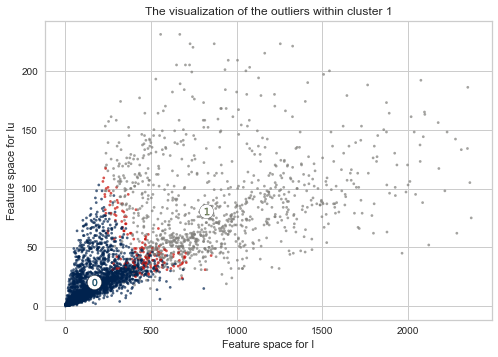

In [28]:
# 2nd Plot showing the actual clusters formed
fig, axs = plt.subplots(1, 1)
axs.scatter(cs[cs.columns[0]], cs[cs.columns[1]], marker='.', s=30, lw=0, alpha=0.7, c=negative_sil_colors, edgecolor='k')

# Draw white circles at cluster centers
axs.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    axs.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

axs.set_title("The visualization of the outliers within cluster 1")
axs.set_xlabel("Feature space for " + cs.columns[0])
axs.set_ylabel("Feature space for " + cs.columns[1])

plt.show()

As expected, the outliers turn out to be points close to the border between the two clusters, a more accurate analysis will be performed when plotting scatterplots associated with different feature spaces.

### Visualizing the clusters and the centroids via scatter plots

In order to better analyze the distribution of customers between the two clusters and identify where the boundary between the latter is less easily definable, we proceed by drawing the graphs belonging to one half of the scatter matrix.

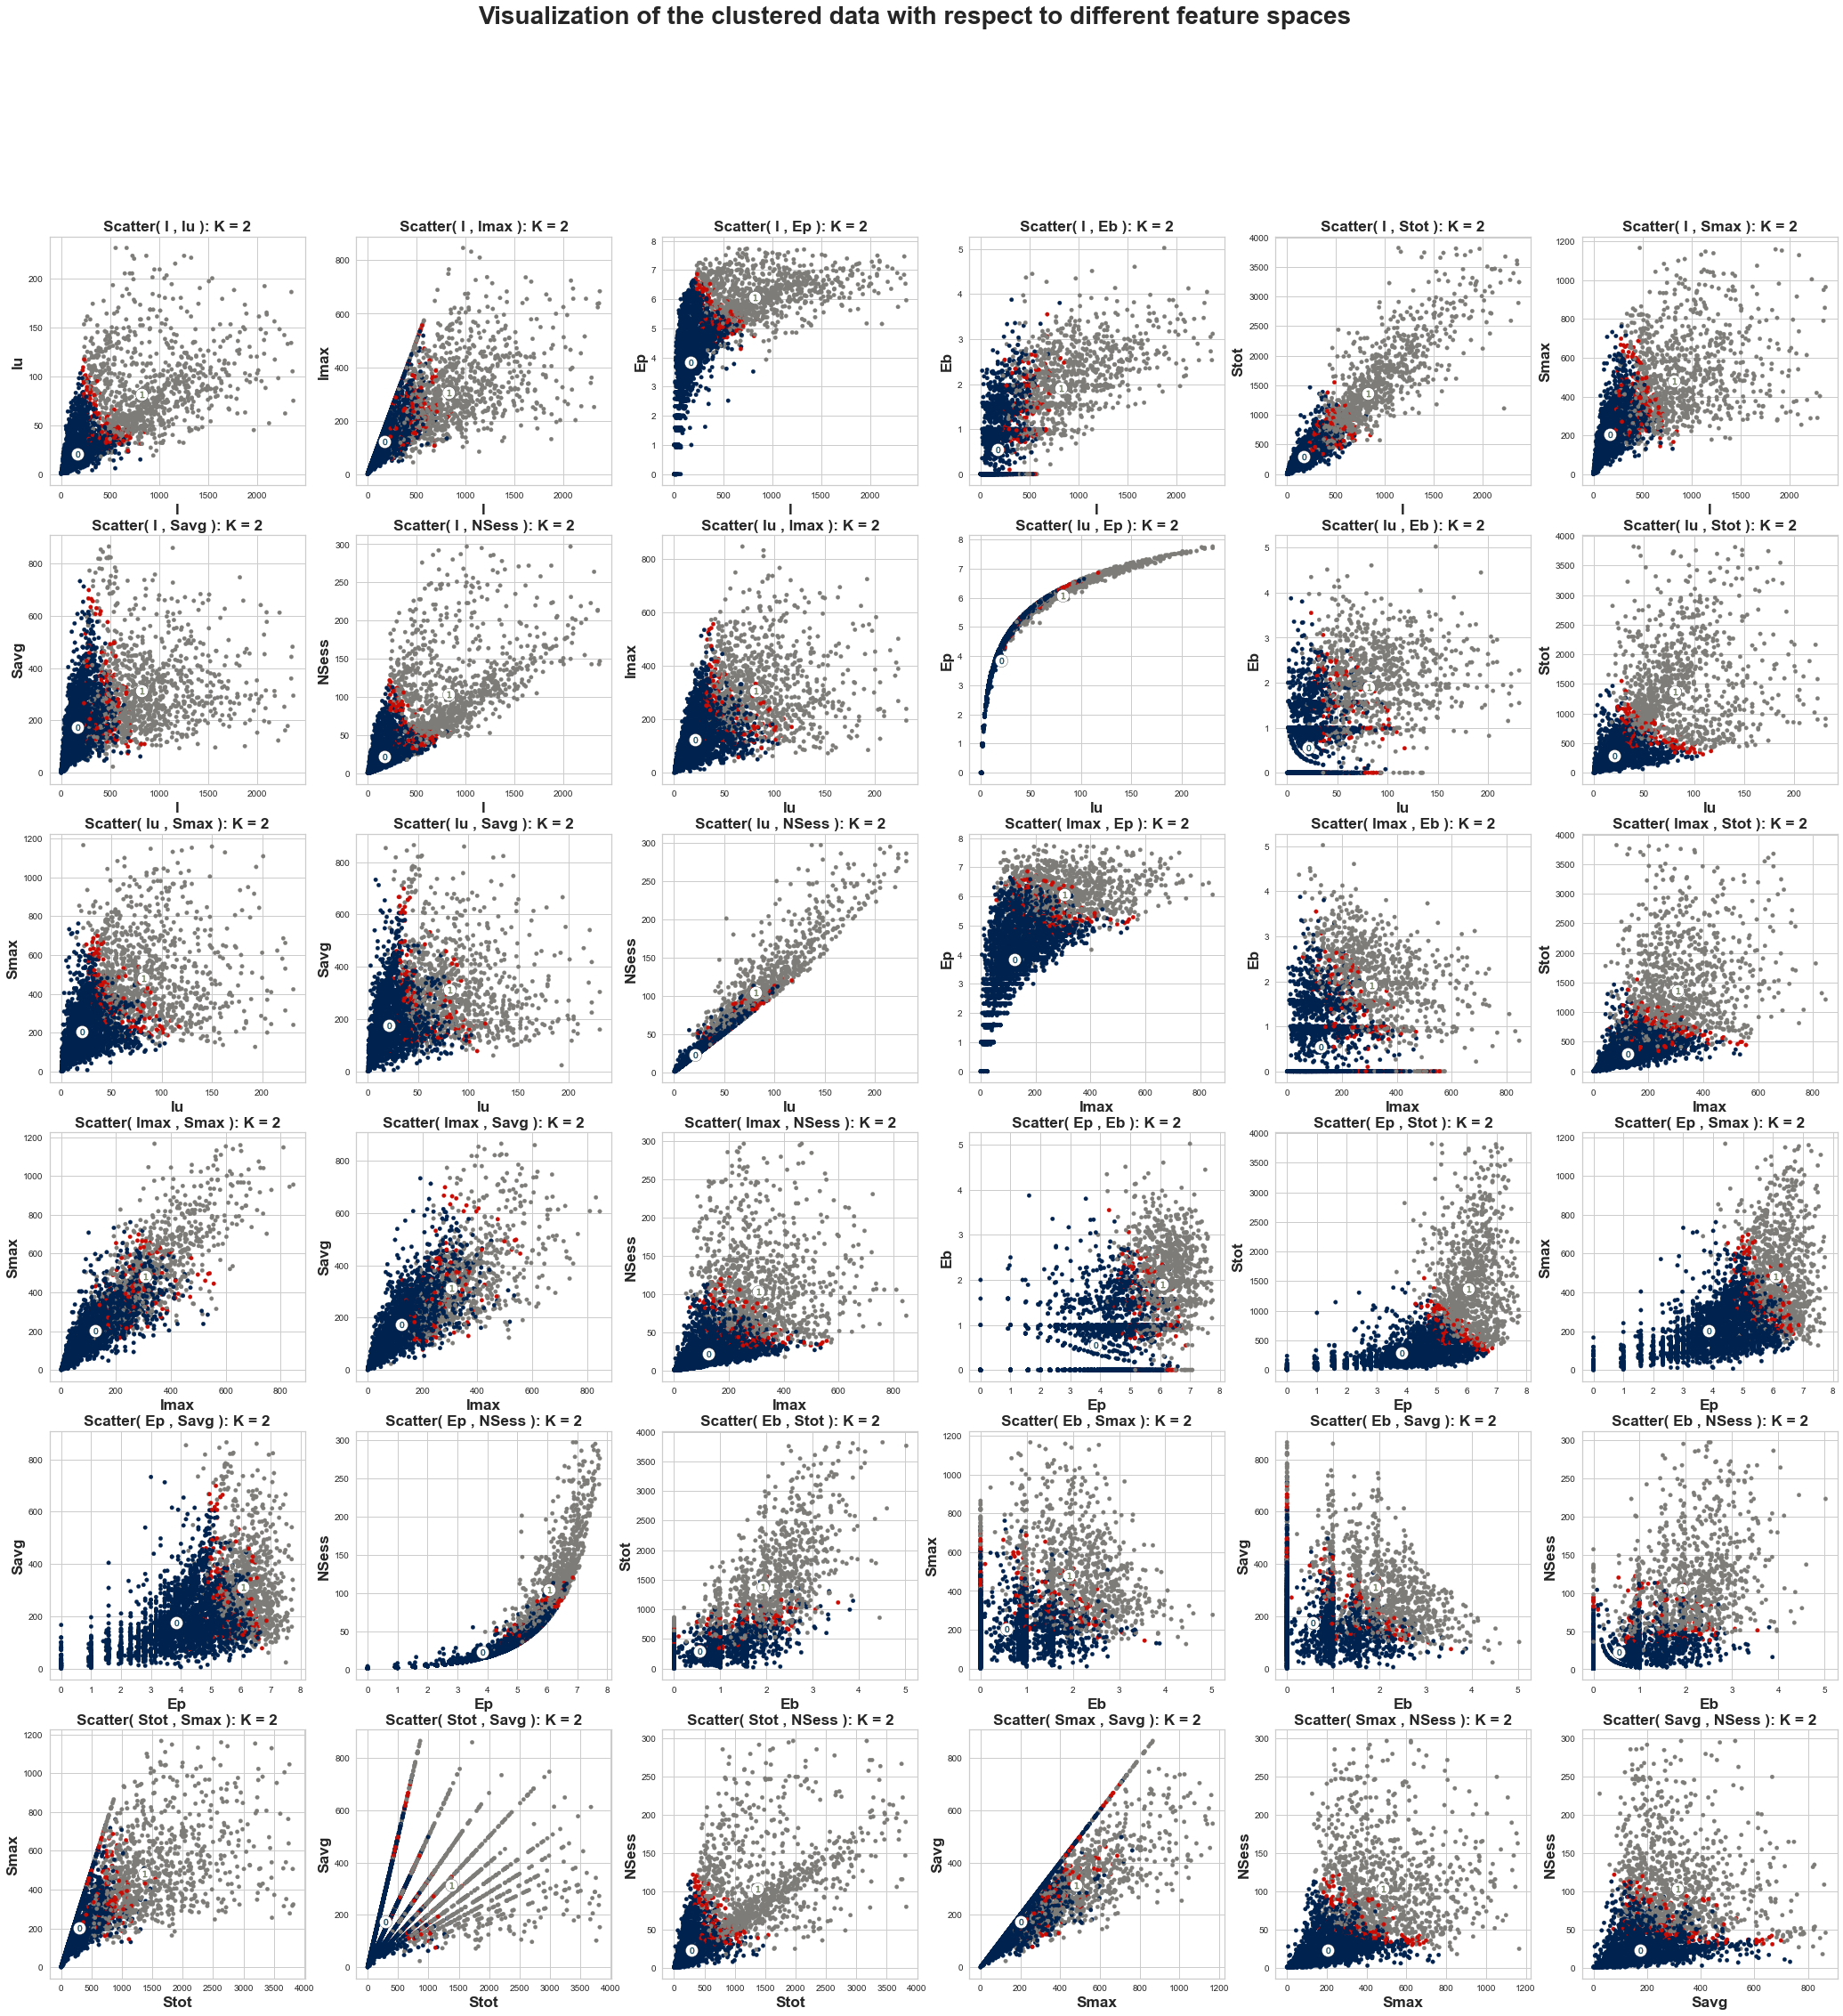

In [29]:
# scatter plots with centroids
f, axs = plt.subplots(nrows=6, ncols=6, figsize=(36,36))
plt.suptitle(("Visualization of the clustered data with respect to different feature spaces"), fontsize=28, fontweight='bold')
plot_id = 0
for i in range(len(cs_num.columns)):
    for j in range(i+1, len(cs_num.columns)):
        a, b = cs.columns[i], cs.columns[j]
        axs[int(plot_id/6)][plot_id%6].scatter(cs[a], cs[b], c=negative_sil_colors, s=20)
        for h in range(len(centers)):
            axs[int(plot_id/6)][plot_id%6].scatter(centers[h][cs.columns.get_loc(a)], centers[h][cs.columns.get_loc(b)], marker='o', c="white", alpha=1, s=200, edgecolor='k')
            axs[int(plot_id/6)][plot_id%6].scatter(centers[h][cs.columns.get_loc(a)], centers[h][cs.columns.get_loc(b)], marker='$%d$' % h, alpha=1, s=50, edgecolor='k')    
        axs[int(plot_id/6)][plot_id%6].set_title('Scatter( ' + a + ' , ' + b + ' ): K = ' + str(k), fontdict={'fontsize': 'x-large', 'fontweight' : 'bold'})
        axs[int(plot_id/6)][plot_id%6].set_xlabel(a, fontdict={'fontsize': 'x-large', 'fontweight' : 'bold'})
        axs[int(plot_id/6)][plot_id%6].set_ylabel(b, fontdict={'fontsize': 'x-large', 'fontweight' : 'bold'})
        plot_id = plot_id +1
plt.show()

It is clear how the two clusters tends to overlap over the common boundary for most of the features under analysis. <br>This indistinction between the regions of clusters 0 and 1 is also characteristic of the points previously marked as outliers, here represented in red.

### Identification of the most influential attributes

We use both the parallel coordinates and the radar plots to display the centroids' value for each of the feature of the dataset.
This provides us a way to determine in which capacity each feature influence the clustering process.

<ipython-input-30-9687b4f0df6c>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axs[1] = plt.subplot(1,k,j+1,polar=True)


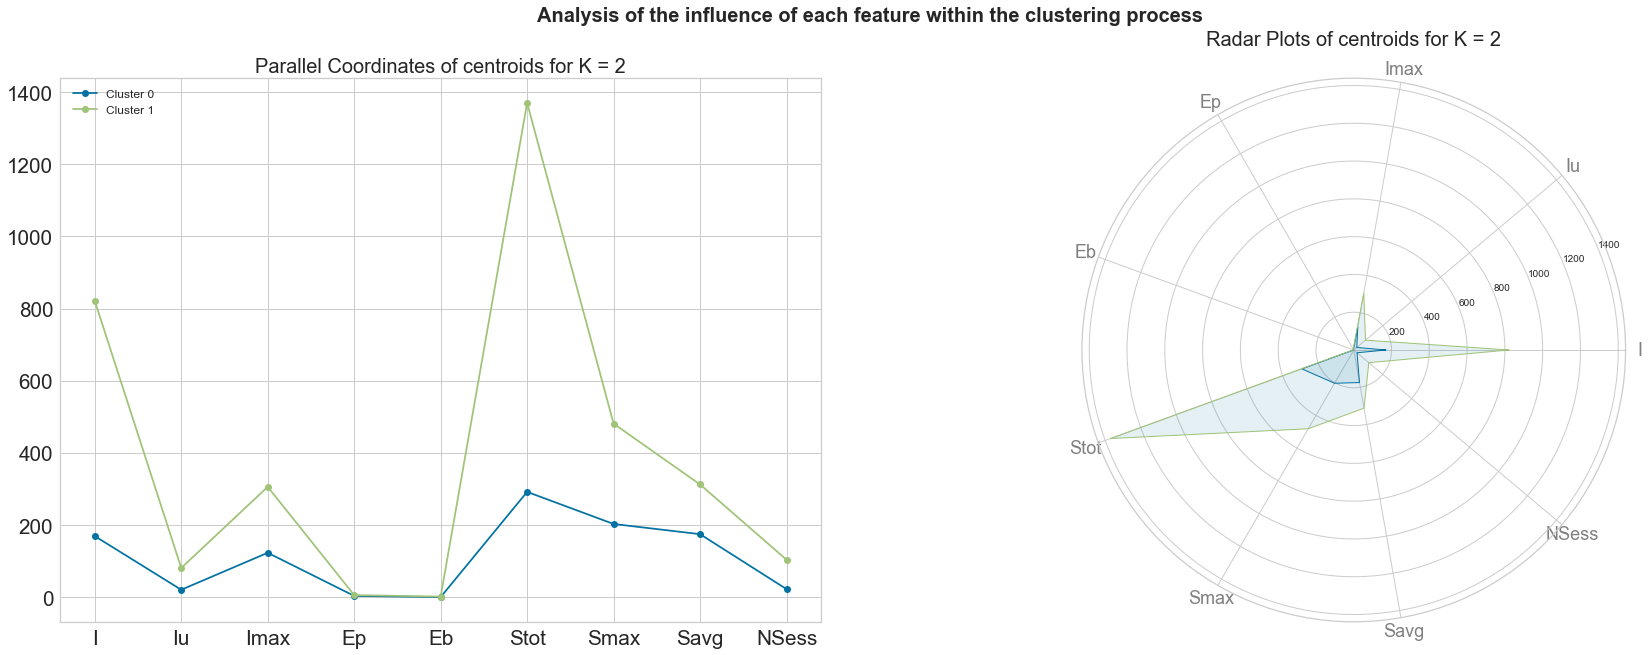

In [30]:
f, axs = plt.subplots(ncols=2, figsize=(30,10))
xlabels = ["0"] + list(cs_num.columns)
N = len(cs_num.columns)

for j in range(0, len(centers)):
    axs[0].plot(centers[j], marker='o', label='Cluster %s' % j)
axs[0].set_xticklabels(xlabels)
axs[0].tick_params(labelsize='xx-large')
axs[0].legend(fontsize=12, bbox_to_anchor=(0.01, 0.99), loc='upper left', borderaxespad=0.)
axs[0].set_title('Parallel Coordinates of centroids for K = ' + str(k), fontsize=20)

for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]
    
    # Initialise the spider plot
    axs[1] = plt.subplot(1,k,j+1,polar=True)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], cs_num.columns, color='grey', size=18) 

    # Plot data
    axs[1].plot(angles, values, linewidth=1, linestyle='solid')
 
    # Fill area
    axs[1].fill(angles, values, 'b', alpha=0.1)
    axs[1].set_title('Radar Plots of centroids for K = ' + str(k), fontsize=20)

plt.suptitle(("Analysis of the influence of each feature within the clustering process"),
             fontsize=20, fontweight='bold')

plt.show()

The graphs above suggest an apparently active participation in the clustering process by all the attributes of the dataset. A more in-depth study will have to be dedicated to the values of the Entropy-based attributes given the difficulty in distinguishing the values associated with the two centroids due to the difference in scale with the remaining attributes. 

Attributes such as I and Stot seem to be the most relevant in distinguishing between points from the two clusters. These conditions encourage the definition of two profiles: 
- **low spending customers** belonging to **cluster 0** and 
- **high spending customers** belonging to **cluster 1**.

We proceed by displaying the values for the Ep (Entropy of the ProductID) and Eb (Entropy of BasketDate) attributes belonging to the two centroids.

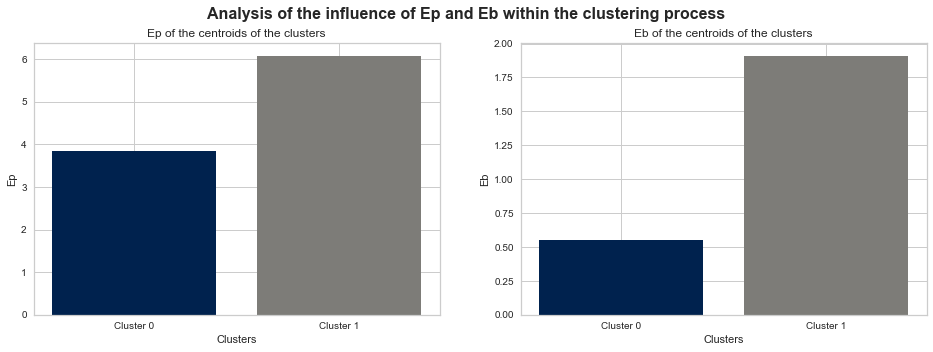

In [31]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

axs[0].bar(['Cluster 0','Cluster 1'], [centers[0][3], centers[1][3]], color=['#00224e','#7d7c78'])
axs[0].set_xlabel('Clusters')
axs[0].set_ylabel('Ep')
axs[0].set_title('Ep of the centroids of the clusters')

axs[1].bar(['Cluster 0','Cluster 1'], [centers[0][4], centers[1][4]], color=['#00224e','#7d7c78'])
axs[1].set_xlabel('Clusters')
axs[1].set_ylabel('Eb')
axs[1].set_title('Eb of the centroids of the clusters')

plt.suptitle(("Analysis of the influence of Ep and Eb within the clustering process"),
             fontsize=16, fontweight='bold')
plt.show()

Considering the two centroids as **ideal examples of low and high spending customers**, we can derive general considerations, regarding the customers belonging to the same clusters, from the values they present for the various features of the dataset.

High spending customers, belonging to cluster 1:
- tend to buy more products than low spending ones (I and Imax)
- tend to consider a greater variety of products (Iu and Ep)
- tend to distribute their purchases across shopping sessions on a less regular basis (Eb)
- tend to spend more (Stot, Smax and Savg)
- tend to initiate more shopping sessions (NSess)

### Categorical Attributes

We continue the analysis by observing the distribution of categorical attributes within the two clusters.

#### Country

Starting from the Country associated with each customer we distinguish each point by its association with the United Kingdom or any other country.

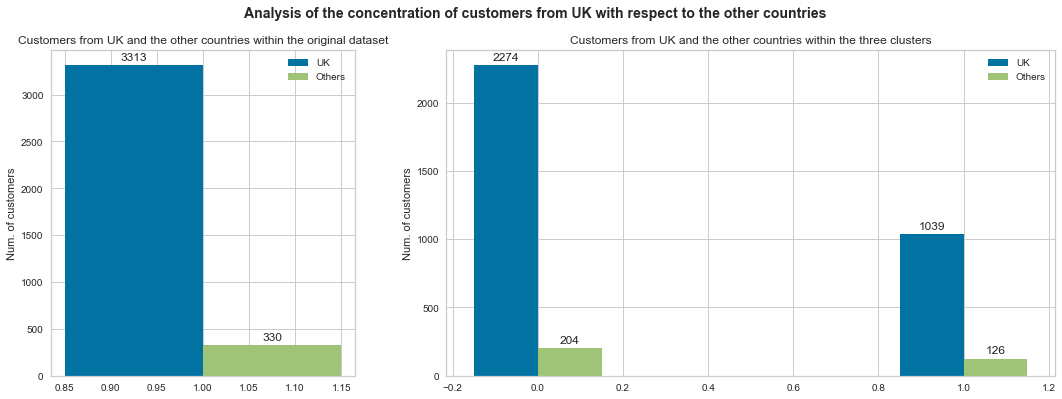

In [32]:
UK_tot = len(cs[cs.Country == 'United Kingdom'])
others_tot = len(cs[cs.Country != 'United Kingdom'])
UK_bar = cs[cs.Country == 'United Kingdom'].groupby([cluster_col, 'Country']).size().unstack()
UK_bar['Others'] = pd.DataFrame(cs[cs.Country != 'United Kingdom'].groupby([cluster_col]).size())

width = 0.15

f, axs = plt.subplots(ncols=2, figsize=(18,6), gridspec_kw={'width_ratios': [1, 2]})
x = np.arange(k)

autolabel(axs[0].bar(1 - width/2, UK_tot, width, label='UK'), 0)
autolabel(axs[0].bar(1 + width/2, others_tot, width, label='Others'), 0)
axs[0].legend()
axs[0].set_ylabel('Num. of customers')
axs[0].set_title('Customers from UK and the other countries within the original dataset')

autolabel(axs[1].bar(x - width/2, UK_bar['United Kingdom'], width, label='UK'), 1)
autolabel(axs[1].bar(x + width/2, UK_bar['Others'], width, label='Others'), 1)
axs[1].legend()
axs[1].set_ylabel('Num. of customers')
axs[1].set_title('Customers from UK and the other countries within the three clusters')

plt.suptitle(("Analysis of the concentration of customers from UK with respect to the other countries "),
             fontsize=14, fontweight='bold')

plt.show()

The vast predominancy of customers coming from the United Kingdom with respect to those from other countries was an expected result. 
We now focus on the customers not coming from the UK. 

We compute the crosstable referring to the distribution among the clusters of the customers from outside of the UK.

In [33]:
# Create cross table
cross_countries=[]
cross_countries = pd.crosstab(cs[cs.Country != 'United Kingdom'][cluster_col], cs[cs.Country != 'United Kingdom'].Country)
cross_countries

Country  Australia  Austria  Bahrain  Belgium  Canada  Channel Islands  \
K_2                                                                      
0                4        6        2       10       2                2   
1                4        3        0       13       0                3   

Country  Cyprus  Czech Republic  Denmark  EIRE  ...  Poland  Portugal  RSA  \
K_2                                             ...                          
0             3               1        4     0  ...       3        10    0   
1             2               0        3     1  ...       2         6    1   

Country  Saudi Arabia  Spain  Sweden  Switzerland  USA  United Arab Emirates  \
K_2                                                                            
0                   1     13       5            8    1                     1   
1                   0      8       3            6    1                     1   

Country  Unspecified  
K_2                   
0                  2  
1                  2  

[2 rows x 33 columns]

In order to account to the difference in dimensions of the clusters, we express the quantity of customers belonging to each country as percentages.

In [34]:
for i in range(len(cross_countries)):
    cross_countries.loc[i] = (cross_countries.loc[i] / cross_countries.loc[i].sum())*100
cross_countries

Country  Australia   Austria   Bahrain    Belgium    Canada  Channel Islands  \
K_2                                                                            
0         1.960784  2.941176  0.980392   4.901961  0.980392         0.980392   
1         3.174603  2.380952  0.000000  10.317460  0.000000         2.380952   

Country    Cyprus  Czech Republic   Denmark      EIRE  ...    Poland  \
K_2                                                    ...             
0        1.470588        0.490196  1.960784  0.000000  ...  1.470588   
1        1.587302        0.000000  2.380952  0.793651  ...  1.587302   

Country  Portugal       RSA  Saudi Arabia     Spain    Sweden  Switzerland  \
K_2                                                                          
0        4.901961  0.000000      0.490196  6.372549  2.450980     3.921569   
1        4.761905  0.793651      0.000000  6.349206  2.380952     4.761905   

Country       USA  United Arab Emirates  Unspecified  
K_2                                                   
0        0.490196              0.490196     0.980392  
1        0.793651              0.793651     1.587302  

[2 rows x 33 columns]

These are the bar plots referring to the customers distributed among the countries different from UK within the original dataset and the clusters.

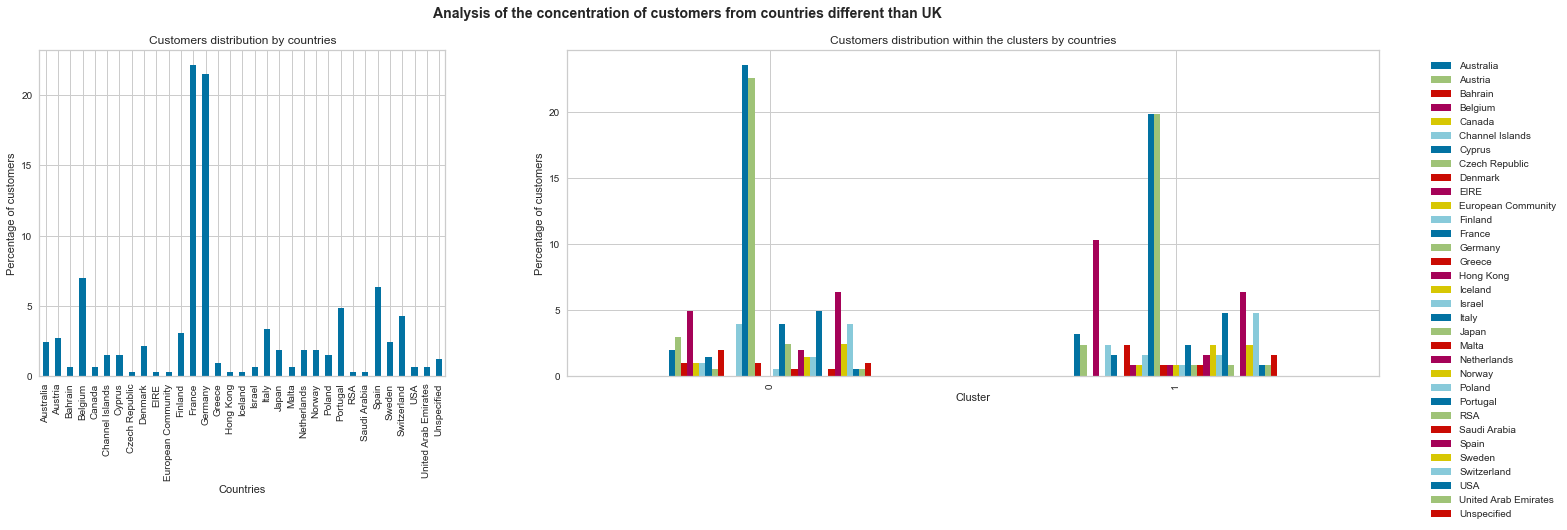

In [35]:
f, axs = plt.subplots(ncols=2, figsize=(24,6), gridspec_kw={'width_ratios': [1, 2]})

country_percentage = (cs[cs.Country != 'United Kingdom'].Country.value_counts().sort_index() / len(cs[cs.Country != 'United Kingdom']))*100
country_percentage.plot(kind='bar', legend=False, ax=axs[0])
axs[0].set_xlabel('Countries')
axs[0].set_ylabel('Percentage of customers')
axs[0].set_title('Customers distribution by countries')

cross_countries.plot(kind='bar', stacked=False, ax=axs[1])
axs[1].set_xlabel('Cluster')
axs[1].set_ylabel('Percentage of customers')
axs[1].set_title('Customers distribution within the clusters by countries')
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.8)

plt.suptitle(("Analysis of the concentration of customers from countries different than UK"),
             fontsize=14, fontweight='bold')

plt.show()

The clients associated with most of the countries above seem to be contained within both clusters and in the same proportions previously identified in the original dataset.

However, clients associated with some particular countries are contained in only one of the two clusters, hence identifying their customers either as low or high spending ones.

The countries associated with customers contained exclusively in cluster 0 are:
- EIRE
- European Community
- Hong Kong
- Iceland 
- RSA

The countries associated with customers contained exclusively in cluster 1 are:
- Saudi Arabia
- Bahrain
- Canada
- Czech Republic


#### Fav_weekday

Now we take a look at the day of the week during which each customer in the two clusters has spent the most.

In [36]:
# Create cross table
cross_week=[]
cross_week = pd.crosstab(cs[cluster_col], cs.Fav_weekday)
weekdays_order = ['Monday', 'Thursday', 'Wednesday', 'Tuesday', 'Friday', 'Saturday', 'Sunday']
cross_week = cross_week[weekdays_order]

As with the Country attribute, we express these quantities as percentages.

In [37]:
for i in range(len(cross_week)):
    cross_week.loc[i] = (cross_week.loc[i] / cross_week.loc[i].sum())*100

These are the bar plots for customers divided by the day of the week they spend the most within the original dataset and clusters.

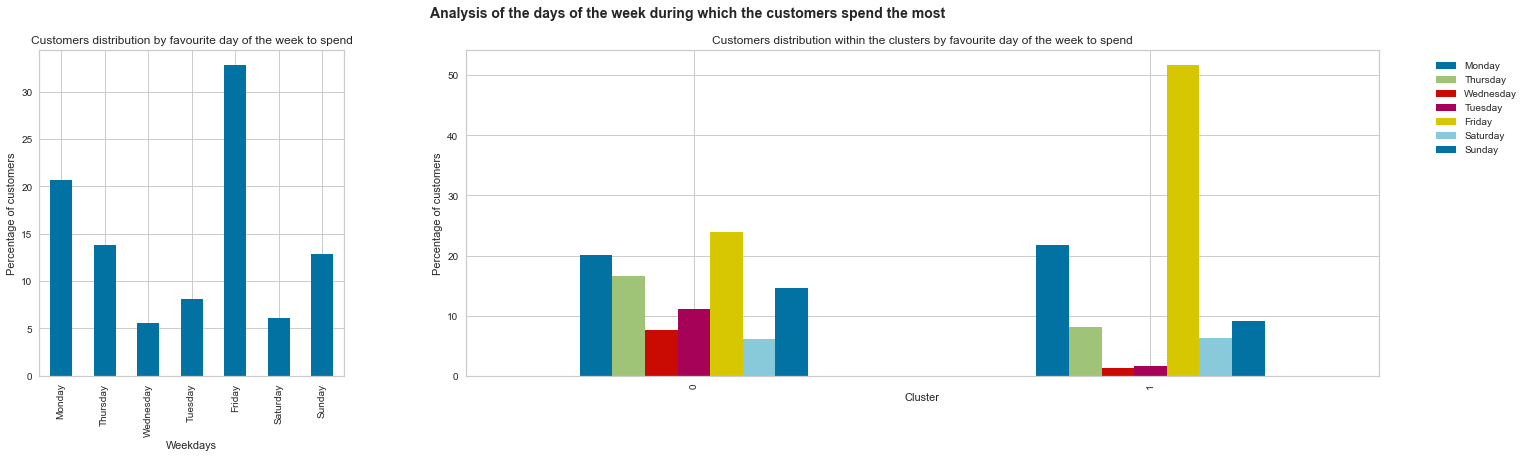

In [38]:
f, axs = plt.subplots(ncols=2, figsize=(24,6), gridspec_kw={'width_ratios': [1, 3]})

week_percentage = ( cs.Fav_weekday.value_counts().to_frame().reindex(weekdays_order) / len(cs) ) * 100
week_percentage.plot(kind='bar', legend=False, ax=axs[0])
axs[0].set_xlabel('Weekdays')
axs[0].set_ylabel('Percentage of customers')
axs[0].set_title('Customers distribution by favourite day of the week to spend')

cross_week.plot(kind='bar', stacked=False, ax=axs[1])
axs[1].set_xlabel('Cluster')
axs[1].set_ylabel('Percentage of customers')
axs[1].set_title('Customers distribution within the clusters by favourite day of the week to spend')
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.8)

plt.suptitle(("Analysis of the days of the week during which the customers spend the most"),
             fontsize=14, fontweight='bold')

plt.show()

According to the graphs above:
- the customers contained in cluster 0 tend to spend the most on Fridays and Mondays, such behaviour is in line with what has been observed within the whole dataset;
- the customers contained in cluster 1 have more regular purchasing behavior, an increase in purchases is still associated with particular days of the week (such as Monday, Tuesday, Friday and Sunday) but the expenses tend to be more evenly distributed.

#### Fav_month

Now we take a look at the month during which each customer in the two clusters has spent the most.

In [39]:
# Create cross table
cross_month=[]
cross_month = pd.crosstab(cs[cluster_col], cs.Fav_month)
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
cross_month = cross_month[months_order]

Again we compute these quantities as percentages in order to deal with the differences in scale among the clusters.

In [40]:
for i in range(len(cross_month)):
    cross_month.loc[i] = (cross_month.loc[i] / cross_month.loc[i].sum())*100

These are the bar plots for customers divided by the month they spend the most within the original dataset and clusters.

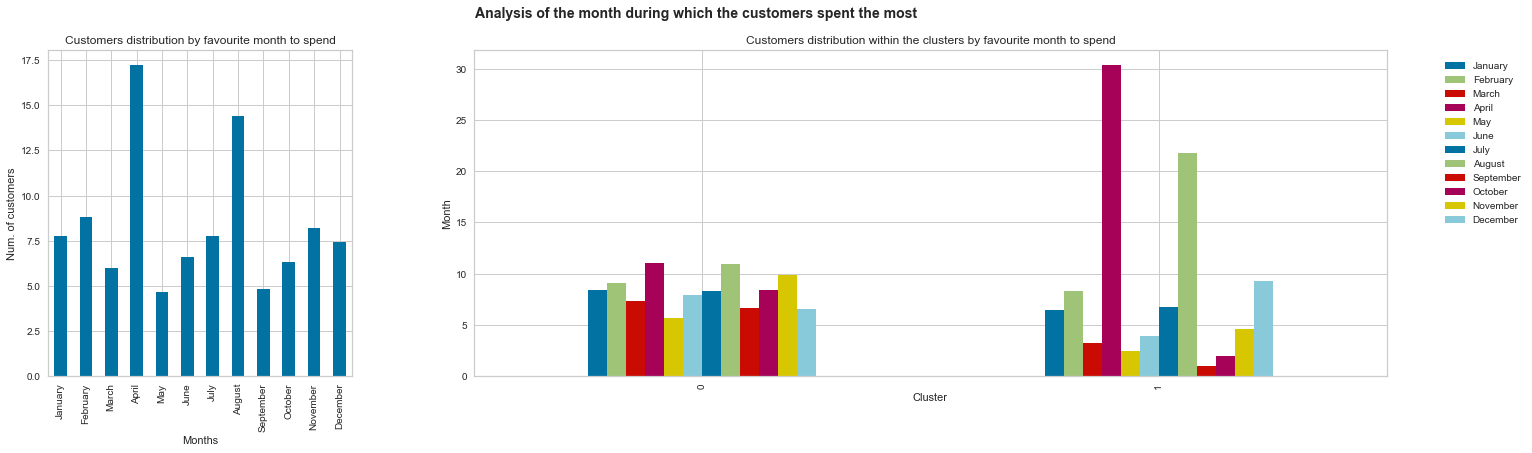

In [41]:
f, axs = plt.subplots(ncols=2, figsize=(24,6), gridspec_kw={'width_ratios': [1, 3]})

month_percentage = ( cs.Fav_month.value_counts().to_frame().reindex(months_order) / len(cs) ) * 100
month_percentage.plot(kind='bar', legend=False, ax=axs[0])

axs[0].set_xlabel('Months')
axs[0].set_ylabel('Num. of customers')
axs[0].set_title('Customers distribution by favourite month to spend')

cross_month.plot(kind='bar', stacked=False, ax=axs[1])
axs[1].set_xlabel('Cluster')
axs[1].set_ylabel('Month')
axs[1].set_title('Customers distribution within the clusters by favourite month to spend')
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.8)

plt.suptitle(("Analysis of the month during which the customers spent the most"),
             fontsize=14, fontweight='bold')

plt.show()

Once again, it is clear that cluster 0 customers tend to drastically increase their purchases close to particular months (such as April and August) while cluster 1 customers tend to have more balanced purchasing behavior throughout the year.

## Evaluation and Comparison of the clustering results
At this point, we are going to use well-known metrics in order to evalueate the clustering obtained with our vlustering via k-means. 
Doing this will grant us a numerical expression of the overall "goodness" of the arrangements of out clusters. 

### Unsupervised evaluation / Internal indices
Several measures of the clusters cohesion and/or separation have been already computed during the identification of the best value for k.
<br>As a reminder we print again the score of our clustering with respect to the aforementioned metrics.

In [42]:
int_metrics_K.loc['K_2']

SSE                   557.294186
Davies_Bouldini         1.002153
Silhouette              0.435007
Calinski_Harabasz    3021.802248
Name: K_2, dtype: float64

**Internal Indices:**
- **SSE** stands for **Sum of Squared Error** and it's a measure of the clusters cohesion
    - It tends to be Inversely proportional to the number of clusters so an high value is expected.
- The **Davies Bouldini Index** is a measure of the clusters separation 
    - Indicating the similarity among clusters, the aim is to achieve the lowest possible value, the value for k equals to 2 was the lowest among the other candidates
- The average **Silhouette Score** is a measure encompassing both density and separation among clusters 
    - An higher score relates to a model with better defined clusters and the score for k equals to 2 was the highest among the other candidates 
- The **Calinski Harabasz Index**, like the Silhouette Score, refers to the quality of both aspects of a cluster's shape  
    - Again, the score for k equals to 2 was the highest among the other candidates

### External Metrics
We now introduce again categorical features to interpret clusters' semantic and to understand how they are distributed.

**External indexes**

The metrics that we are going to use are:
- **Similarity** between original features and labels found by the algorithm.
- **Homogeneity** that measures if clusters are homogeneous wrt class labels. A value equal to 1 means that cluster are of the same type of the original label (i.e. categorical feature).
- **Completeness** measures how much original labels are concentrated in specific clusters.
- **Mutual Information** is a function that measures the agreement of the two assignments (i.e. original classes and labels assigned by the algorithm), ignoring permutations.

In [43]:
ext_metrics=pd.DataFrame()

temp=[]
sim=[]
hom=[]
compl=[]
mutinfo=[]

# wrt categorical features
for column in cs_cat:
    temp.append(column)
    sim.append(metrics.adjusted_rand_score(cs_cat[column], cs[cluster_col]))
    hom.append(metrics.homogeneity_score(cs_cat[column], cs[cluster_col]))
    compl.append(metrics.completeness_score(cs_cat[column], cs[cluster_col]))
    mutinfo.append(metrics.normalized_mutual_info_score(cs_cat[column], cs[cluster_col], average_method='arithmetic'))

ext_metrics['Feature'] = temp
ext_metrics['Similarity'] = sim
ext_metrics['Homogeneity'] = hom
ext_metrics['Completeness'] = compl
ext_metrics['Mutual Information'] = mutinfo

ext_metrics.set_index(['Feature'], inplace=True)
ext_metrics

Similarity  Homogeneity  Completeness  Mutual Information
Feature                                                               
Country        0.016213     0.007975      0.006979            0.007444
Fav_weekday   -0.002892     0.032975      0.092852            0.048667
Fav_month      0.004861     0.026229      0.100570            0.041607

# Clustering analysis by density clustering

The main aim of density-based algorithms is to find **dense regions of space**, i.e. areas in which there is an agglomeration of points.
The notion of density, as well as the way in which we can quantify this "agglomerations", are determined by the choice of parameters.

Density-based clustering methods differ from k-means in the fact that they **do not specify the number of clusters beforehand**. Moreover, unlike other clustering methods, they **incorporate a notion of outliers and are able to “filter” these out**. 

## DBSCAN algorithm

We perform the density-based clustering using DBSCAN (*Density-Based Spatial Clustering of Applications with Noise*) algorithm.

It has only two parameters...
* **eps**: The maximum distance between two samples for them to be considered as in the same neighborhood.
* **min_samples**: the minimum number of points needed to create a cluster.

... and one output:
* cluster **labels** for each point in the dataset. Noisy samples are given the label -1.

### Pre-processing
Since the dataset normalization has been already done, is is not necessary to do here any further preprocessing step. We will use the previously normalized dataset (with Min-Max approach) to perform DBSCAN.

## Parameters tuning 
In order to understand which is the optimal assignment for both the parameters, we had to do a lot of executions and trials, exploring different combinations of values (see the table in section **Statistics** below).

We tried different values for the *min_sample* parameter (also called *k* in this context) in order to know how many neightbors we had to consider in a region with radius *eps* (second parameter) so that we can appropriately call that region a "cluster".
Then we did the same process viceversa, so that by fixing a radius *eps* and deriving the *k* parameter.
This double evaluation ensures a **more precise and stable tuning** of our parameters. 

Then, using the **knee method** we selected the candidates as best values of *eps*, for all the *min_sample* tried.

The whole process is clearly visible in the plots below.

### Knee method (fixed neighbors)

#### With few neighbors

As first step we try to perform an evaluation considering a number of neightbors between 6 and 12.
Later we will the same analysis buth with a greater number of samples.

In [44]:
from scipy.spatial.distance import pdist, squareform
dist = pdist(cs_norm_minmax, 'euclidean') #pair wise distance
print (dist)
dist = squareform(dist) #distance matrix given the vector dist

[0.70695545 0.89143646 0.78651529 ... 0.35370397 1.30116011 1.16398196]


Thanks to visualization tool we can estimate where the value of *epsilon* parameter gets lower and lower, since it becomes stable. 

In particular, we create several plots experimenting different values for *k* to have a stronger confirm of what are the best associations for different values of *k* and *eps* parameters.

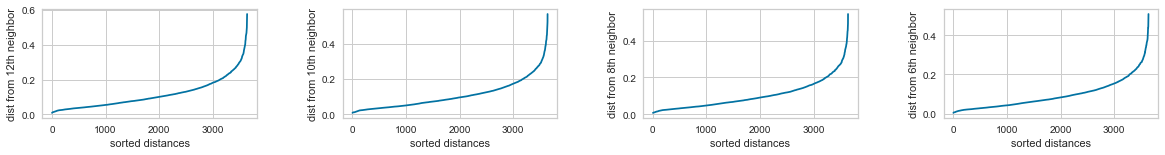

In [45]:
# Set up a grid of plots:
fig = plt.figure(figsize=(20,2))
fig_dims = (1, 4)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

k = 12
    
for i in range(0,1):
    for j in range(0,4):
        plt.subplot2grid(fig_dims, (i,j))
        kth_distances = list()
        for d in dist:
            index_kth_distance = np.argsort(d)[k]
            kth_distances.append(d[index_kth_distance])
        plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
        plt.ylabel('dist from %sth neighbor' % k)
        plt.xlabel('sorted distances')
        plt.tick_params(axis='both', which='major')
        plt.grid(True)
        
        k-=2

From these plots it seems clear that the **candidates values for *epsilon* parameter are between 0.1 and 0.3**.

#### With many neighbors

Now we execute the same evaluation but testing with a number of neightbors above 12.

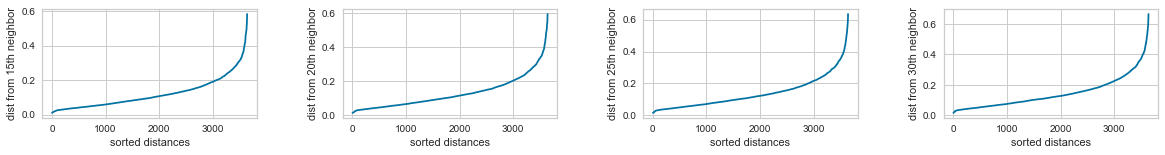

In [46]:
# Set up a grid of plots:
fig = plt.figure(figsize=(20,2))
fig_dims = (1, 4)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

k = 15
    
for i in range(0,1):
    for j in range(0,4):
        plt.subplot2grid(fig_dims, (i,j))
        kth_distances = list()
        for d in dist:
            index_kth_distance = np.argsort(d)[k]
            kth_distances.append(d[index_kth_distance])
        plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
        plt.ylabel('dist from %sth neighbor' % k)
        plt.xlabel('sorted distances')
        plt.tick_params(axis='both', which='major')
        plt.grid(True)
        
        k+=5

Also in the case, the *eps* value starts decreasing at 0.3 and becomes pretty stable at 0.1.

So for both the few-neighbor and the more-neighbor cases, **the results for *epsilon* evaluation is the same**.

To confirm which is exacly the best value, for each respective *k* quantiy of neightbors, we did a lot of executions, summarized in the table below, in section **Statistics**. 

Moreover, to ensure a correct tuning of parameters, we did the same process but viceversa, so that by fixing *epsilon* and deriving the best value for *k*. This process is described below.

### Knee method (fixed epsilon)
At this point, just to be sure that our parameter evaluation is correct, we execute an analogous analysis but this time we fix the *epsilon* parameter rather than the number of neightbors.

So by choosing epsilon we build a density plot for this fixed radius and look for an elbow there.

Usually this method is recommended when having a domain knowledge to choose epsilon (e.g. 1 meter, when you have a geo-spatial data and know this is a reasonable radius).


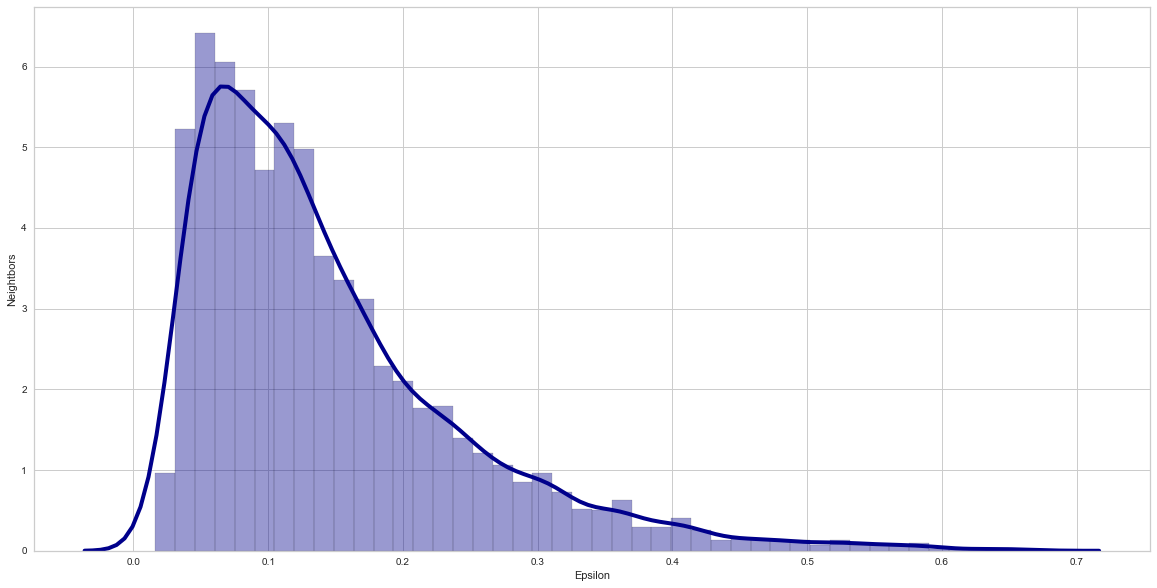

In [47]:
fig = plt.figure(figsize=(20,10))
fig_dims = (20, 20)

# Density Plot and Histogram of all arrival delays
sn.distplot(kth_distances, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.ylabel('Neightbors')
plt.xlabel('Epsilon')
plt.tick_params(axis='both', which='major')
plt.grid(True)
        

## Running DBSCAN with different configurations of parameters

In [48]:
from sklearn.cluster import DBSCAN

In [49]:
# INPUT
# dbscan = DBSCAN(eps=0.55, min_samples=15) # algorithmic parameters
# dbscan.fit(cs_norm_minmax)

In [50]:
eps_values = [0.35,0.3,0.12,0.1,0.09,0.08,0.08,0.09,0.1,0.11,0.12,0.09,0.2,0.1,0.1,0.11,0.09, 0.12,0.1,0.11,0.12,0.9]
min_samples_values = [5,5,20,20,20,20,25,25,25,25,25,30,30,30,10,10,10,10,8,8,8,8]
dbscan = [] 

for i in range(len(eps_values)): 
    d = DBSCAN(eps=eps_values[i], min_samples=min_samples_values[i]) # algorithmic parameters
    dbscan.append(d)
    dbscan[i].fit(cs_norm_minmax)

In [51]:
# OUTPUT
dbscan[0].labels_
# dbscan[1].labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [52]:
dbscan[0]

DBSCAN(eps=0.35)

## Statistics
In this section we print some statistics about all the different runs we executed, in order to understand which of those gives the best result and so **which configuration of parameters is the best**.

For each run of the algorithm, and so for each different combination of the two parameters, we compute:
- the number of clusters founded
- how much noise the algorithm has detected
- the number of record for each cluster (i.e. the population)

The table below summarizes all the statistics we computed, but also all the trials we did during parameter tuning phase.

It is very useful for doing interesting considerations about the results we obtained.

In [53]:
dbscan_complete = pd.DataFrame()

number_of_classes = []
n_noise = []
dbs_run=[]

for i in range(len(eps_values)): 
    number_of_classes.append(np.unique(dbscan[i].labels_).shape[0])
    n_noise.append(list(dbscan[i].labels_).count(-1))
    dbs_run.append(i+1)

In [54]:
# dbscan_complete['DBSCAN case'] = dbs_run
dbscan_complete['K'] = min_samples_values
dbscan_complete['Eps'] = eps_values
dbscan_complete['Number of clusters'] = number_of_classes

In [55]:
zero_population = []
one_population = []
two_population = []
for i in range(len(eps_values)): 
    zero_population.append(list(dbscan[i].labels_).count(0))
    one_population.append(list(dbscan[i].labels_).count(1))
    two_population.append(list(dbscan[i].labels_).count(2))

dbscan_complete['Noise label'] = -1
dbscan_complete['Noise population'] = n_noise
dbscan_complete['Population of cluster 0'] = zero_population
dbscan_complete['Population of cluster 1'] = one_population
dbscan_complete['Population of cluster 2'] = two_population

dbscan_complete

K   Eps  Number of clusters  Noise label  Noise population  \
0    5  0.35                   2           -1                 7   
1    5  0.30                   3           -1                21   
2   20  0.12                   3           -1              1099   
3   20  0.10                   4           -1              1435   
4   20  0.09                   3           -1              1652   
5   20  0.08                   4           -1              1933   
6   25  0.08                   4           -1              2030   
7   25  0.09                   5           -1              1793   
8   25  0.10                   3           -1              1550   
9   25  0.11                   4           -1              1366   
10  25  0.12                   4           -1              1204   
11  30  0.09                   4           -1              1899   
12  30  0.20                   2           -1               439   
13  30  0.10                   4           -1              1639   
14  10  0.10                   5           -1              1146   
15  10  0.11                   4           -1              1007   
16  10  0.09                   6           -1              1384   
17  10  0.12                   4           -1               862   
18   8  0.10                   8           -1              1085   
19   8  0.11                   4           -1               932   
20   8  0.12                   3           -1               786   
21   8  0.90                   1           -1                 0   

    Population of cluster 0  Population of cluster 1  Population of cluster 2  
0                      3636                        0                        0  
1                      3619                        3                        0  
2                      2477                       67                        0  
3                      2122                       67                       19  
4                      1925                       66                        0  
5                      1171                      473                       66  
6                      1151                      396                       66  
7                      1193                      557                       66  
8                      2027                       66                        0  
9                      2185                       67                       25  
10                     2353                       67                       19  
11                     1186                      492                       66  
12                     3204                        0                        0  
13                     1904                       66                       34  
14                     2402                       67                       14  
15                     2552                       67                       17  
16                     2141                       67                       13  
17                     2693                       67                       21  
18                     2442                       67                        8  
19                     2636                       67                        8  
20                     2790                       67                        0  
21                     3643                        0                        0


To make some considerations on this long phase of parameter tuning, we can say that we have noticed better performances with a high number of neighbors and we have also noticed that a difference of just 0.01 in the value of the *epsilon* parameter can be really relevant (it can even change the number of cluster detected).

### Best configuration of parameters
What emerges from the previous analysis on parameters tuning (further supported by some tests on data visualization that we did in this preliminary phase that are not reported here) is that the best combination of parameters to use with this dataset to perform the DBSCAN algorithm are:

- *min_sample* = 10, *eps* = 0.11

which corresponds to run 15 in the table above.

As a matter of fact, this combo **returns the best configuration** in terms of number of clusters detected and the meaning of this clusters (see the *Post processing analysis* section below) and the best balance between noise points and clusters points. For more precise considerations about noise, see the *Final considerations* section below.



In [56]:
cs_clusters['DBSCAN'] = dbscan[15].labels_

## Visualization of density-based clustering in two dimensions
### Scatter plots
Now we plot all the features correlations in order to fully visualize all the dense regions detected.

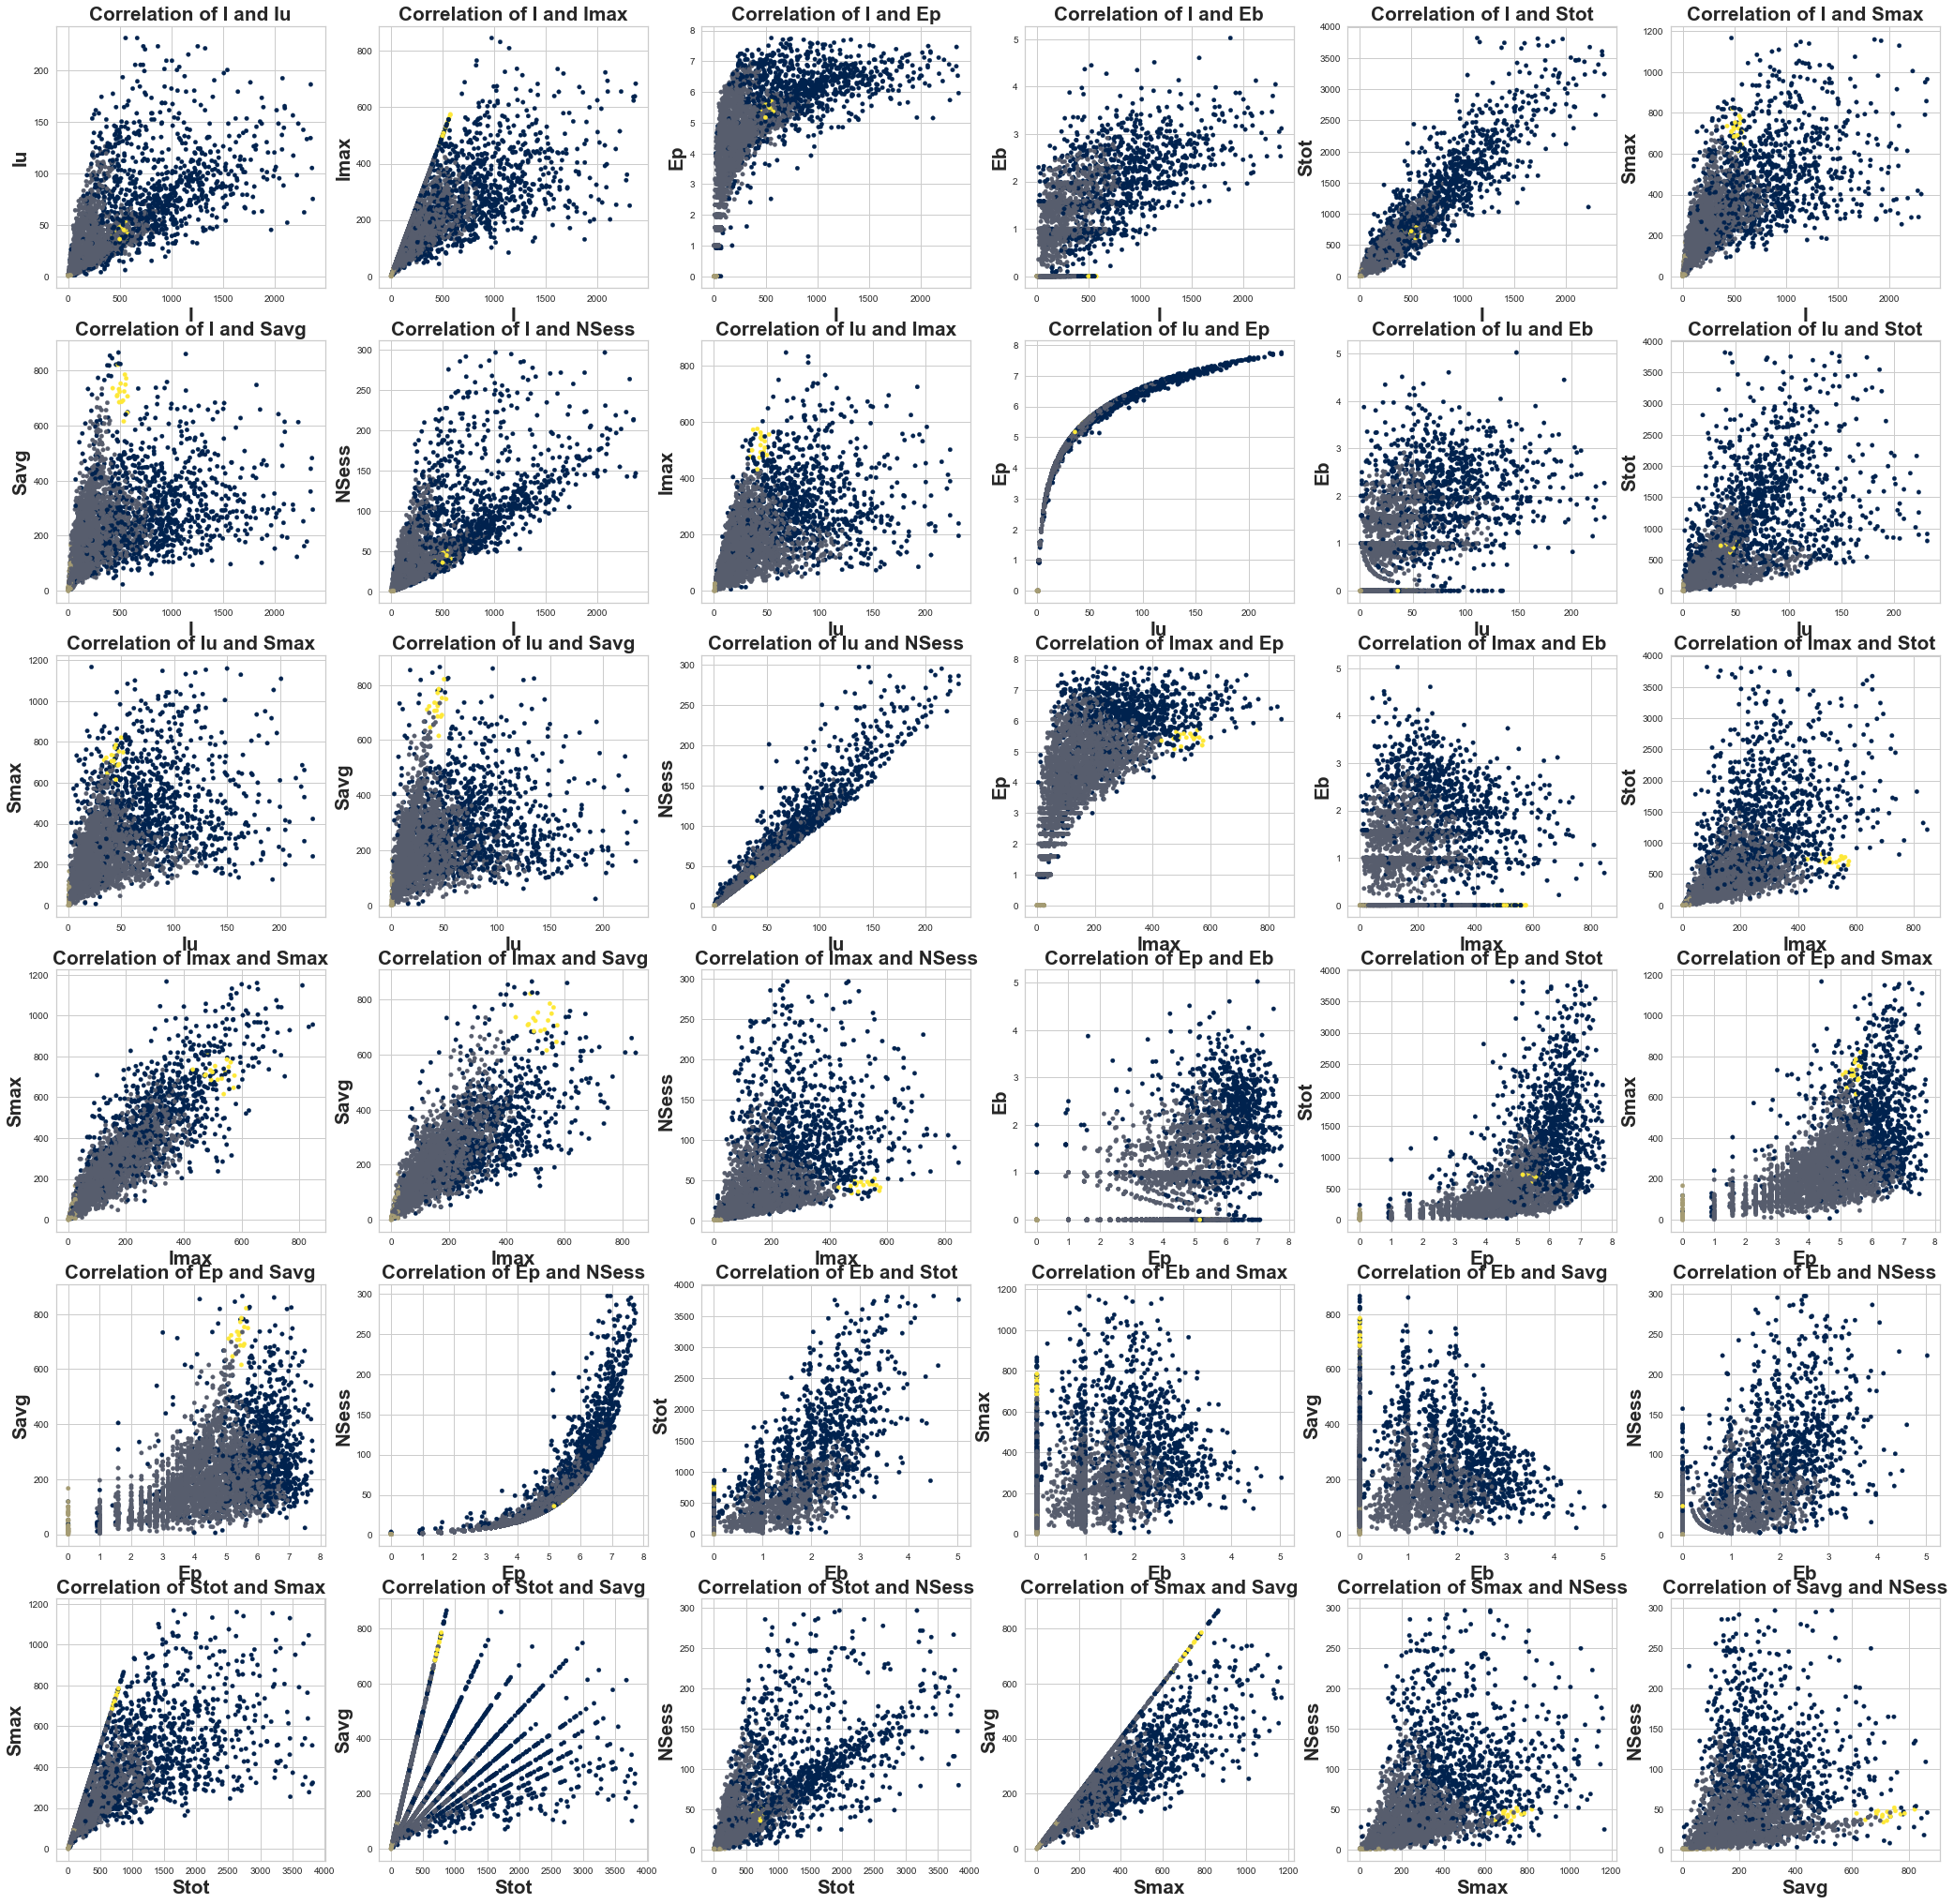

In [57]:
f, axs = plt.subplots(nrows=6, ncols=6, figsize=(36,36))
index = 0
for i in range(0,len(cs_num.columns)):
    for j in range(i+1,len(cs_num.columns)):
        axs[int(index/6)][index%6].scatter(cs[cs.columns[i]], cs[cs.columns[j]], c=dbscan[15].labels_, s=20, cmap=cm.cividis)
        axs[int(index/6)][index%6].set_title('Correlation of ' + cs.columns[i] + ' and ' + cs.columns[j], fontdict={'fontsize': 'xx-large', 'fontweight' : 'bold'})
        axs[int(index/6)][index%6].set_xlabel(cs.columns[i], fontdict={'fontsize': 'xx-large', 'fontweight' : 'bold'})
        axs[int(index/6)][index%6].set_ylabel(cs.columns[j], fontdict={'fontsize': 'xx-large', 'fontweight' : 'bold'})
        index = index + 1


It is easy to see that DBSCAN is able to detect clusters having non-globular shape.

Now, for a better visualization, we zoom on one of this plot. We choose for esample the correlation between *I* and *Savg* indicators just because it seems really interesting to visualize.

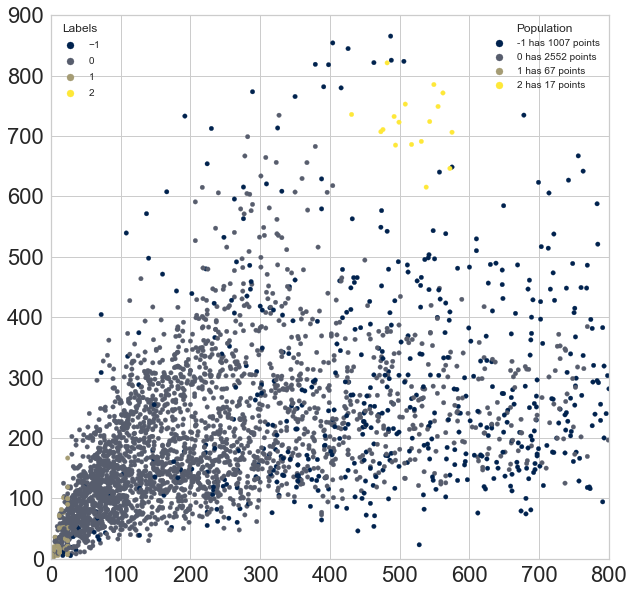

In [58]:
dbs_population = np.unique(dbscan[15].labels_, return_counts=True)

fig, ax = plt.subplots(figsize=(10, 10))
scatter = plt.scatter(cs['I'], cs['Savg'], c=dbscan[15].labels_, # these labels will be used to create a legend
            s=20, cmap=cm.cividis)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.axis([0,800,0,900])

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(), #legend_elements creates legend handles and labels for a PathCollection.
                    loc="upper left", title="Labels")
ax.add_artist(legend1)

# produce a legend 
secondlegend = []
classes = np.unique(dbscan[15].labels_).shape[0]

for i in range(classes):
    secondlegend.append("{} has {} points".format(i-1, dbs_population[1][i]))
handles = scatter.legend_elements()[0]
labels = secondlegend
legend2 = ax.legend(handles, labels, loc="upper right", title="Population")

### Comments on data visualization results
What we can observe at a first glance from these plots is that DBSCAN seems to have these features:


* **Robustness to noise**. It is clearly evident one of the major advantage of the density-based clustering: it is able to detect whatever it recognizes as noise and to label it as -1.
* **Ability to capture clusters with different shapes**. The yellow cluster is clearly a non-globular cluster but DBSCAN can easily detect it.
* **Unable to detect variable densities**. This is a well known limitation of DBSCAN algorithm, and here we have the opportunity to clearly see it: in the second interpretation we proposed, the 'agglomerate' in yellow is the most dense part and so it is correctly recognized as a cluster, but the purple one is classified as noise just because it is less dense that the other. To make a comparison, k-means algorithm instead classified that region as a separate cluster.

## Post-processing analysis
**Extra: Visualization aids**

In [59]:
# useful changes for visualization
cs_clusters['DBS15'] = dbscan[15].labels_
cs['DBS15'] = dbscan[15].labels_

### Population of clusters
Since density-based clustering algorithms do not have the possibility of deciding *a priori* the number of clusters, it is useful to plot the labels' population in order to visualize **how many clusters** the algorithm has found and also the **size** of each of them (i.e. how many points each cluster contains).

In [60]:
# using the same colors as before for a better interpretability 
# extracted from scatter plots by "handles[i].get_color()" 

color = [(0.267004, 0.004874, 0.329415, 1.0), (0.190631, 0.407061, 0.556089, 1.0), (0.20803, 0.718701, 0.472873, 1.0), (0.993248, 0.906157, 0.143936, 1.0)]

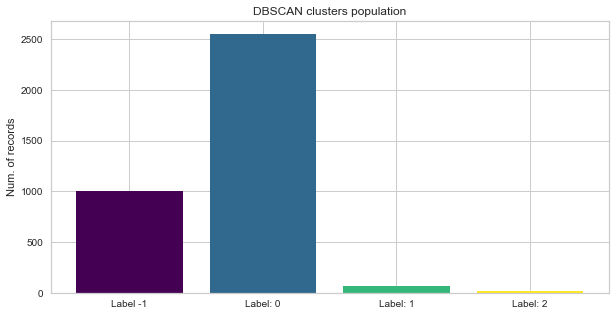

In [61]:
f, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

v_labels = ['Label -1', 'Label: 0', 'Label: 1', 'Label: 2']
hist = [dbscan_complete['Noise population'][15], dbscan_complete['Population of cluster 0'][15], dbscan_complete['Population of cluster 1'][15], dbscan_complete['Population of cluster 2'][15]]    
bins = np.histogram(dbscan[15].labels_, bins=number_of_classes[0])
axs.bar(list(range(0, len(set(dbscan[15].labels_)))), hist, color = color, tick_label=v_labels)
axs.set_title('DBSCAN clusters population')
axs.set_ylabel('Num. of records')

plt.show()

It is easy to see that DBSCAN has recognized two bigger clusters (one of which is labeled as noise) and two smaller ones.
Now we proceed with their analysis to understand how they are composed.

### Study of smaller clusters
In order to understand what these two smaller clusters represent, we do here a more in depth analysis to interpret them.

Therefore we **plot the distribution of all the indicators for each single cluster**.

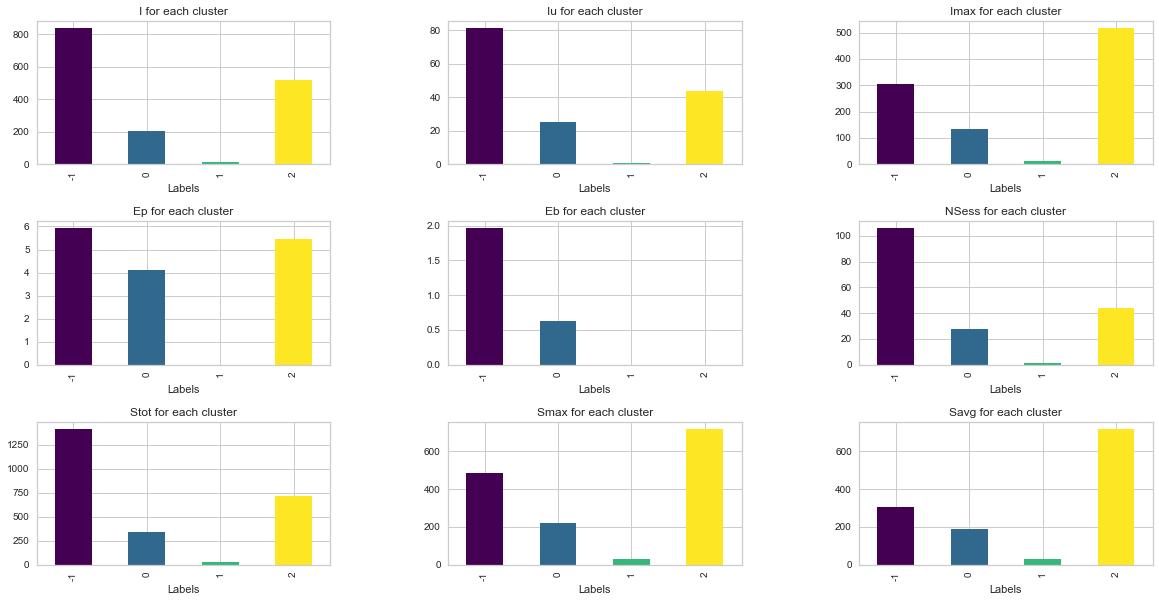

In [62]:
# Set up a grid of plots:
fig = plt.figure(figsize=(20,10))
fig_dims = (3, 3)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

indicators = ['I', 'Iu', 'Imax'] 
indicators2 = ['Ep', 'Eb', 'NSess']
indicators3 = ['Stot', 'Smax', 'Savg']


for j in range(0,3):
    plt.subplot2grid(fig_dims, (0,j))
    cs.groupby('DBS15')[indicators[j]].mean().plot(kind='bar',  color=color) 
    plt.title(indicators[j] + ' for each cluster' )
    plt.xlabel('Labels')


for j in range(0,3):
    plt.subplot2grid(fig_dims, (1,j))
    cs.groupby('DBS15')[indicators2[j]].mean().plot(kind='bar',  color=color) 
    plt.title(indicators2[j] + ' for each cluster' )
    plt.xlabel('Labels')

for j in range(0,3):
    plt.subplot2grid(fig_dims, (2,j))
    cs.groupby('DBS15')[indicators3[j]].mean().plot(kind='bar',  color=color) 
    plt.title(indicators3[j] + ' for each cluster' )
    plt.xlabel('Labels')

plt.show()

## Clusters interpretations
Thanks to the visualization tool, by plotting the indicators distributions among all the clusters, what we discover is that the DBSCAN was able to **detect and distinguish groups of customers having different purchasing behaviour**. 

 

### Label 2: wholesale customers (i.e. *grossisti*)
They are those who bought **the highest number of items and who spent the most** (both total and average), all **within a single shopping session**. Their Eb indicator (Shannon's Entropy on the number of baskets) is really low: this confirms that they did the lowest number of shopping sessions. 

Moreover, since the Shannon's Entropy on the types of products purchased by the customer (Ep indicator) is high, they are buying different kind of products.

For these two reasons we called them the *wholesalers*: as a matter of fact, the shopping behavior of this group of customers perfectly suggests that they can be stockists (in italian: *grossisti*).

This group name also allows us to distinguish them from others gropus of customers, havig different behavior in doing shopping, and so **having a different semantic and meaning in how they buy**. For example, they are distinguished from families, single customers, and so on.


*considerazioni sul fatto che sono un'élite e che possono essere dei grossisti, non per esempio una famiglia perchè (controllare -->) sono bel al di sopra dei valori medi*

### Label 1: low-spending customers profile
Customers from cluster 1 have a low-spending behavior.
They spend a little, they buy very few products and not of various types. They make very few carts.

### Label 0: medium-spending customers
Customers from cluster 0 are clearly those identified by a medium-spending behavior.
Their expenses and both the number and the types of products they bought are average.

### Label -1: high-spending customers
Instead those customers classified as noise (-1 label) are those who still have an high-spending tendency buth with a different behavior: **they are not high-spending in one shopping session, but they're purchases are spread over many sessions**.

In fact they have higher values of:
- both total and distinct number of items purchased
- total amount spent,
- and the most important one, the number of shopping sessions done 

The distributions of this attributes is perfectly coherent with the description we gave to these groups of customers.

## Unsupervised evaluation measures: internal indexes
Now we reinfoce this observations based on data viasualization with numerical informations by measuring the goodness of a clustering structure without respect to external information. An example of this is the SSE. Unsupervised measures of cluster validity are often further divided into two classes: 
- measures of cluster **cohesion** (compactness, tightness), which determine how closely related the objects in a cluster are
- measures of cluster **separation** (isolation), which determine how distinct or well-separated a cluster is from other clusters. 

Unsupervised measures are often called internal indices because they use only information present in the data set.

- Source: [*Introduction to Data Mining (Second Edition)*](https://www-users.cs.umn.edu/~kumar001/dmbook/index.php), **chapter 7.5: *Cluster Evaluation***, p. 573

### Silhouette and separation scores

The silouhette score describes not only the cohesion but also separation between clusters (it is able to capture if clusters are well separated or not). A value of silhouette equal to 1 means that there is a good cohesion and separation between clusters.

Notice that if there actually are subclusters that are not separated very well from one another, the silhouette score may provide only a coarse view of the cluster structure of the data.


In [63]:
from sklearn import metrics

sil = silhouette_score(cs_norm_minmax, dbscan[15].labels_)
sep = metrics.davies_bouldin_score(cs_norm_minmax, dbscan[15].labels_)

print('\nSilhouette score: ' + str(sil))
print('Separation score: ' + str(sep))


Silhouette score: 0.1888658623578415
Separation score: 0.9001989082430663


The result shows that the two obtained clusters are well-separated, but not so cohesive.

It must be also said that **none of the unsupervised cluster validity measures does well for density-based clusters** ([*Introduction to Data Mining (Second Edition)*](https://www-users.cs.umn.edu/~kumar001/dmbook/index.php), *General Comments on Unsupervised Cluster Evaluation Measures*, pp. 582-583).

## Supervised evaluation measures: external indexes
We now introduce again categorical features to interprete clusters' semantic and to understand how they are distributed.

**External indexes**

The metrics that we are going to use are:
- **Similarity** between original features and labels found by the algorithm.
- **Homogeneity** that measures if clusters are homogeneous wrt class labels. A value equal to 1 means that cluster are of the same type of the original label (i.e. categorical feature).
- **Completeness** measures how much original labels are concentrated in specific clusters.
- **Mutual Information** is a function that measures the agreement of the two assignments (i.e. original classes and labels assigned by the algorithm), ignoring permutations.

In [64]:
from sklearn import metrics

dbs=pd.DataFrame()

temp=[]
sim=[]
hom=[]
compl=[]
mutinfo=[]

# wrt categorical features
for column in cs_cat:
    temp.append(column)
    sim.append(metrics.adjusted_rand_score(cs_cat[column], dbscan[15].labels_))
    hom.append(metrics.homogeneity_score(cs_cat[column], dbscan[15].labels_))
    compl.append(metrics.completeness_score(cs_cat[column], dbscan[15].labels_))
    mutinfo.append(metrics.normalized_mutual_info_score(cs_cat[column], dbscan[15].labels_, average_method='arithmetic'))

dbs['Feature'] = temp
dbs['Similarity'] = sim
dbs['Homogeneity'] = hom
dbs['Completeness'] = compl
dbs['Mutual Information'] = mutinfo
dbs

Feature  Similarity  Homogeneity  Completeness  Mutual Information
0      Country    0.010692     0.016735      0.013050            0.014665
1  Fav_weekday   -0.009026     0.030410      0.076304            0.043488
2    Fav_month    0.001902     0.027894      0.095307            0.043157

What we get from this analysis is that these categorical features (months, weekdays and countries) are not representative of how data is clusterized. This is a further confirmation of what we discovered before, i.e. the clustering process was made by the algorithm following the spending behavior criterion.

## Relative evaluation measures: Entropy
A relative cluster evaluation measure is a supervised or unsupervised evaluation measure that is used for the purpose of comparison (i.e. to compare different clusterings or clusters). Thus, relative measures are not actually a separate type of cluster evaluation measure, but are instead a specific use of such measures. 

For this reason now we compare the different clusters detected by the DBSCAN algorithm by computing and reporting **entropy measure for each cluster**, with respect to each single attribute.

Entropy measures the degree to which each cluster consists of objects of a single feature. An entropy of 0 is considered good.


- Source: [*Introduction to Data Mining (Second Edition)*](https://www-users.cs.umn.edu/~kumar001/dmbook/index.php), **chapter 7.5: *Cluster Evaluation***, p. 577, 590

In [65]:
# Shannon entropy on the purchasing behaviour of the customer
def estimate_shannon_entropy(values):
    m = len(values)
    IDs = collections.Counter([value for value in values])
    shannon_entropy_value = 0
    for ID in IDs:
        # number of residues
        n_i = IDs[ID]
        # n_i (# residues type i) / M (# residues in column)
        p_i = n_i / float(m)
        entropy_i = p_i * (math.log(p_i, 2))
        shannon_entropy_value += entropy_i
    if shannon_entropy_value == 0:
        return 0

    return shannon_entropy_value * -1

In [66]:
# computing entropy for each indicator
E = pd.DataFrame()
for i in dbs['Feature']: 
    e = cs.groupby(by=['DBS15'])[i].apply(estimate_shannon_entropy)
    E['Entropy of ' + str(i)] = e
E

Entropy of Country  Entropy of Fav_weekday  Entropy of Fav_month
DBS15                                                                  
-1               0.858409                1.987749              2.925876
 0               0.753470                2.655365              3.548579
 1               0.304895                2.658737              3.387674
 2               1.556901                2.145136              2.822182

What we get from this analysis is that, except for the entropy of *Country* feature that is quite near to zero for cluster 1, all the other results confirm the fact that these categorical attributes are not representative of the clusters composition (in fact their entropy is very high).

## Clustering validation by Similarity Matrix

If we are given the similarity matrix for a data set and the cluster labels from a cluster analysis of the data set, then **we can evaluate the “goodness” of the clustering** by looking at the correlation between the similarity matrix and an ideal version of the similarity matrix based on the cluster labels.

More specifically, an ideal cluster is one whose points have a similarity of 1 to all points in the cluster, and a similarity of 0 to all points in other clusters. Thus, if we sort the rows and columns of the similarity matrix so that all objects belonging to the same cluster are together, then an ideal cluster similarity matrix has a block diagonal structure. In other words, the similarity is non-zero, i.e., 1, inside the blocks of the similarity matrix whose entries represent intra-cluster similarity, and 0 elsewhere. 

- Source: [*Introduction to Data Mining (Second Edition)*](https://www-users.cs.umn.edu/~kumar001/dmbook/index.php), **chapter 7.5.3**, sections *Unsupervised Cluster Evaluation Using the Proximity Matrix* and *Measuring Cluster Validity via Correlation*, pp. 582-585

### Building similarity matrix


#### Proximity matrix
Computed using the [SciPy distance matrix](scipy.spatial.distance_matrix).

In [67]:
cs_copy = pd.DataFrame()
cs_copy['DBS_labels'] = cs_clusters['DBS15']
cs_copy['data_point'] = cs_clusters.index
cs_copy.index = pd.RangeIndex(len(cs_copy)) # define an index from 0 to (len(data))
cs_copy = cs_copy.sort_values(by='DBS_labels')

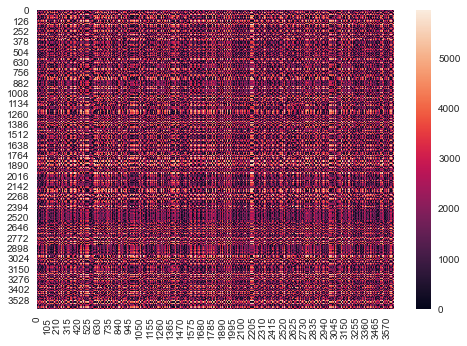

In [68]:
from scipy.spatial import distance_matrix
dist_matrix = distance_matrix(cs_copy, cs_copy)
ax = sn.heatmap(dist_matrix)

#### Incidence matrix
The ideal cluster similarity matrix (aka **incidence matrix**) is constructed by creating a matrix that has one row and one column for each data point just like an actual similarity matrix and assigning a 1 to an entry if the associated pair of points belongs to the same cluster. All other entries are 0.

In [70]:
n = len(cs_copy['DBS_labels'])
inc_matrix = []
for i in range(n):
    row = []
    for j in range(n):
        if cs_copy['DBS_labels'][i] == cs_copy['DBS_labels'][j]: # check the cluster affiliation
            row.append(1) # assign 1 if records belongs to the same cluster, 0 otherwise
        else:
            row.append(0)
    inc_matrix.append(row)

### Measuring Cluster Validity via Correlation
Now we compute the correlation between the two matrices.
High correlation indicates that points that belong to the same cluster are close to each other.

In [71]:
# computing the correlation matrix
corr_matrix = np.corrcoef(dist_matrix, inc_matrix)

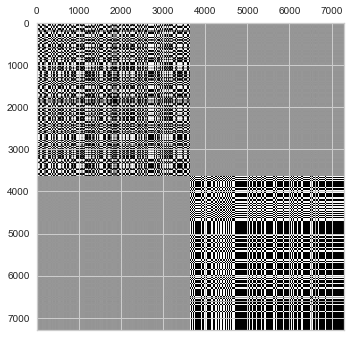

In [72]:
# visualization
plt.matshow(corr_matrix) 
plt.show()

### Judging a Clustering Visually by its Similarity Matrix
The image shows the resulting similarity matrix sorted by DBSCAN cluster labels.
Since **clusters are well-separated** (as shown by internal indexes during unsupervised evaluation of clusters) **they show a very strong, block-diagonal pattern** in the reordered similarity matrix.

What results from the densit-based clustering evaluation by similarity matrix is that the points belonging to the same cluster are close enough to each other. However, there are also some weak block diagonal patterns in the reordered similarity matrix of the clusterings found by DBSCAN.

### Further observations about this approach

"High correlation between the ideal and actual similarity matrices indicates that the points that belong to the same cluster are close to each other, while low correlation indicates the opposite." (Source: *Measuring Cluster Validity via Correlation* in [*Introduction to Data Mining (Second Edition)*](https://www-users.cs.umn.edu/~kumar001/dmbook/index.php), Chapter 7, p. 584)


Consequently, although the method still reported good results in this DBSCAN clusters evaluation, in general, **the similarity matrix is not a good measure for many density- or contiguity-based clusters** because they are not globular and can be closely intertwined with other clusters.



#### Complexity
This approach may seem hopelessly expensive for large data sets, since the computation of the proximity matrix takes *O(m^2)* time, where *m* is the number of objects, but with sampling, this method can still be used.

## Clusters interpretation via categorical attributes

We now proceed with a further evaluation of density-based clustering results.

In order to understand even better how clusters populations are distributed, we now build some cross tables and barplot with respect to categorical features in order to find a possible further interpretation of DBSCAN clustering.

We already know from the results of the evaluation through external indices that these categorical features will not be very representative of clusters' composition.
In fact, we have already seen that the clustering process is based on the spending behavior of customers.

However, we proceed with this analysis considering it as a further confirmation of what has been said.

We report a complete analysis for each categorical attribute.

### Country attribute

In [73]:
cross_Country=[]
# Create cross tables
cross_Country.append(pd.crosstab(dbscan[15].labels_, cs.Country))

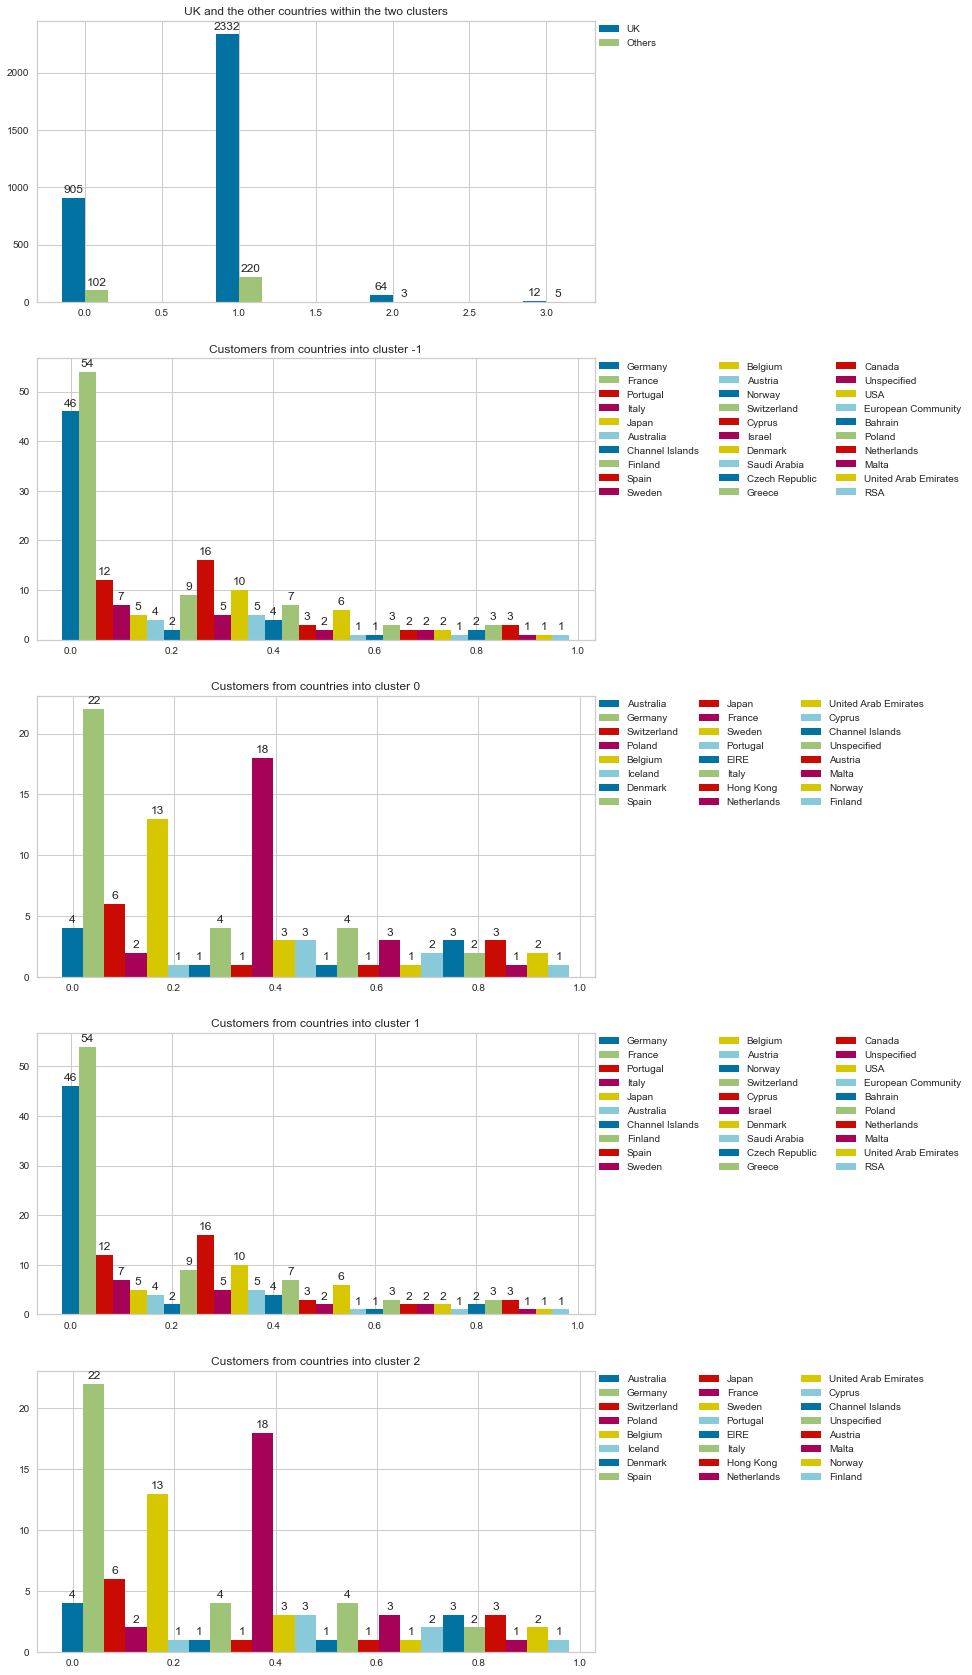

In [74]:
d_visual_labels=['Cluster -1','Cluster 0','Cluster 1', 'Cluster 2']

UK_bar = cs[cs.Country == 'United Kingdom'].groupby(['DBS15', 'Country']).size().unstack()
UK_bar['Others'] = pd.DataFrame(cs[cs.Country != 'United Kingdom'].groupby(['DBS15']).size())

other_countries = [[] for _ in range(2)]
other_values = [[] for _ in range(2)]
lab =[-1, 0]
for cluster in lab:
    for country in cs[(cs.Country != 'United Kingdom') & (cs.DBS15 == cluster)].Country.unique():
        other_countries[cluster].append(country)
        other_values[cluster].append(cs[(cs.DBS15 == cluster) & (cs.Country == country)].Country.count())
 
x = np.arange(len(d_visual_labels))
width = 0.15

f, axs = plt.subplots(nrows=5, figsize=(10,30))
autolabel(axs[0].bar(x - width/2, UK_bar['United Kingdom'], width, label='UK'), 0)
autolabel(axs[0].bar(x + width/2, UK_bar['Others'], width, label='Others'), 0)
axs[0].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
axs[0].set_title('UK and the other countries within the two clusters')

for i in [-1,0,1,2]:
    for j in range(len(other_countries[i-1])):
        point = (1/len(other_countries[i-1]) * j)
        autolabel(axs[i+2].bar( point, other_values[i-1][j], (1/len(other_countries[i-1])), label=other_countries[i-1][j]), i+2)
        axs[i+2].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0., ncol=3)
    axs[i+2].set_title('Customers from countries into cluster ' + str(i))
    
plt.show()

The analysis of the distribution of the *country* attribute whithin the clusters is not meaningful, given that the most represented customers are always Germans and French. Since the distribution is similar among all the clusters, this analysis is not meaningful for the interpretation of the results. We have already seen, in fact, that the division made by the algorithm (and so the correct interpretation to give) is according to purchasing behavior, and not to the country of origin.

### Weekday attribute
Now we try again to interprete the cluster distribution but with respect to a new attribute, that is *Fav_weekday*. It represents the day of the week when customers spent the most (i.e. their favourite day for doing purchases).

We first check the population of this attribute for each cluster, building a cross table, and then we visualize it with a barplot.

In [75]:
# Create cross table
cross_week=[]
cross_week = pd.crosstab(dbscan[15].labels_, cs.Fav_weekday)

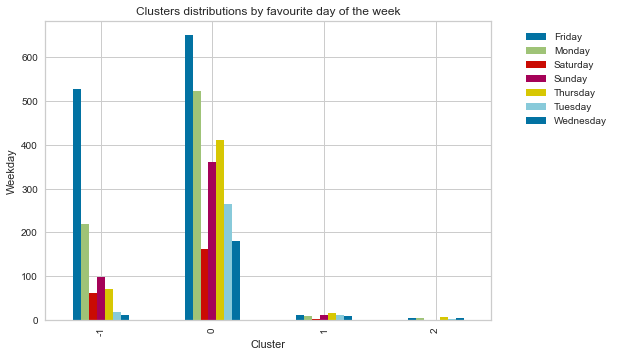

In [76]:
cross_week.plot(kind='bar', stacked=False, title='Clusters distributions by favourite day of the week')
plt.xlabel('Cluster')
plt.ylabel('Weekday')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.8)
plt.show()

This analysis confirms the results we got of k-means post-processing phase: the favourite day for customers to go shopping is Friday. 

However, the same conclusion of the *country* attribute must be done: the analysis of the distribution of the *favorite weekday* attribute is not meaningful for the interpretation of the clustering results. We have already seen that the subdivision made by the algorithm (and so the correct interpretation to be given) is according to purchasing behavior, and not weekday.

### Month attribute
The last interpretation of clusters is made with respect to *Fav_month* attribute, that represents the month in which the customers spent the most (i.e. their favourite month for doing purchases).

We first check the population of this attribute for each cluster, building a cross table, and then we visualize it with a barplot.

In [77]:
# Create cross table
cross_month=[]
cross_month = pd.crosstab(dbscan[15].labels_, cs.Fav_month)

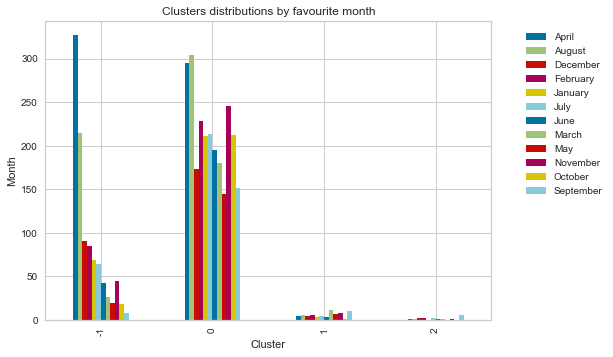

In [78]:
cross_month.plot(kind='bar', stacked=False, title='Clusters distributions by favourite month')
plt.xlabel('Cluster')
plt.ylabel('Month')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.8)
plt.show()

Again, even if we have discovered another interesting information, i.e. the preferred months for customers to shop are April and August, this kind of analysis is not meaningful for the interpretation of the clustering results, as the distribution of this feature is more or less similar for each single cluster. This confirms that the correct interpretation is that of spending behavior.

## Final considerations

*Points in low-density regions are classified as noise and omitted; thus, DBSCAN does not produce a complete clustering*. 

Kumar Book, chapter 7, page 533

### Two possible interpretations for noise in DBSCAN

In the previous analysis we have seen that the cluster identified as noise (-1 label) actually represents a different group with respect to shopping behavior: it represents those high-spending customers who, however, spread their purchase into many shopping sessions. 
So, since this seems to represent a proper cluster and not what we usually know as *noise*, we want to distinguish here 
two different perspectives by which noise label in DBSCAN can be interpreted. Depending on these interpretations, both correct in our opinion, we can recognize two possible outcomes:

* *Interpretation 1*: DBSCAN assignes a -1 label to those records That we properly call *noise*, i.e. data points that are far from dense areas (so distant from other clusters).

* *Interpretation 2*: since DBSCAN is not able to recognize clusters with diffrent densities, it cannot assign a separate cluster to the less-dense region and so it automatically labels that region with -1 : in this case, the meaning of this label is *not* representing the usual definition of *noise*, but just the **inability of DBSCAN to recognize two different clusters with different densities**. 

In our case we are clearly in the perspective number 2: **since the less-dense area, reprensenting a cluster with a specific behavior, is difficult to be recognized properly as a cluster** (because of this intrinsic limitation of DBSCAN algorithm), it is still well distiguished and separated from the others, but **it has been given the *noise* label**. Coherently with this interpretation, -1 points are not what we properly call *noise*, but a less-dense cluster, and so it is the demonstration of this already known algorithmic limitation.

In support this hypotesis, please see again both the scatter plots above in the data visualization section (where it is easy to see the lower density of that area) and the interpretations in post-procesing analysis section.


## DBSCAN conclusions
Since "*density-based definition of a cluster is often employed when [...] noise and outliers are present*" (Kumar book, chapter 7, pp. 532-533), we argue that DBSCAN is **not** the best algorithm for clustering on this data. In fact we had previously performed a deep cleaning of the data itself, removing outliers and noise (see "Task1"). Therefore, the literature broadly supports that the optimal algorithm for a dataset like this one, already treated and cleaned up, is a contiguity-based approach. Confirming these theories we have in fact noticed that clustering with k-means returns the best results. This also perfectly explains why the DBSCAN algorithm has classified a specific group of customers (the high-spending ones) as noise (label -1).

### Pros
- Deciding *a priori* the number of clusters is not needed: the algorithm is able to discover them by itself.
- Robust wrt noise: it detects noisy points and assigns them a -1 label (instead in K-Means they're assigned to the closest centroid)
- Is able to find clusters with any shape (not only globular / spherical shape as K-Means does), because there is no notion of *centroids* here.

### Cons

Density-based clustering methods are somewhat **harder to tune** compared to parametric clustering methods like K-Means. Things like the epsilon parameter for DBSCAN are less intuitive to reason about compared to the number of clusters parameter for K-Means, so it’s more difficult to pick good initial parameter values for these algorithms.

As a matter of fact, we had to do a lot of executions in order to tune parameters in a sufficient good way (see above *Parameter tuning*).

Another limit of DBSCAN algorithm is that it **not able to recognize different densities**: "*DBSCAN can have trouble with density if the density of clusters varies widely*" (Kumar book, chapter 7, page 569).
From the scatter plots above it is easy to see that DBSCAN does not works very well in varying-densities environment. For this reason we had to distinguish between two possible noise interpretations.

## Clustering Analysis by Hierarchical Clustering

Hierarchical approaches to clustering are useful when having an nested structure among the cluster is a necessity. The main drawbacks of such approaches are the time and space performances and, for this reasons, they're usually combined with other clustering analysis like k-means.

The hierarchy of clusters can be visualized with a dendogram: a tree structure where the horizontal lines represent the merging of two nodes, or clusters, and the vertical line provides information regarding the distance (or similarity) between said elements. By the end of the agglomerative bottom-up process, the dendrogram ends up displaying the whole merging process leading to a single universal cluster. Every number of clusters can be obtained by cutting the tree at the right level / height.

**About distances**

The first step is to compute the matrix accounting the distances among each of the point in our dataframe. Said computing can be performed by the **scipy** function **pdist** or by specifying the a particulare metric as a parameter of the **AgglomerativeClustering** class of **Sklearn**. 

Both alternatives are able to compute distances with respect to several well-known metrics or even custom ones specifically defined by the user. 
For the sake of this analysis, and due to the rich presence of continuous numerical data, we are going to select the **Euclidean distance** as our metrics of choice.

**About linkage**

The second step is usually to chose a linkage method, that is chosing *how* the computation of the aforementioned distance is going to be performed. Again, the list of methods for linkage contains several choices, mainly leading to:
- Min / Single-linkage
    - the proximity between two clusters is based on the proximity of the two closest points
    - it tends to perform similarly to DBSCAN
    - is able to recognize non-elliptical clusters
    - is notoriously sensitive to noise and outliers
- Max / Complete-Linkage
    - the proximity between two clusters is based on the proximity of their fartherst points
    - it is more resistant than the single-linkage to outliers and noise
    - is known for breaking the larger clusters into smaller globular ones 
- Average-linkage
    - a trade-off between the complete and single linkages: the proximity between two clusters is the average of the pairwise proximity between the points of the two clusters
    - as the complete linkage, it is less susceptible to noise and outliers
    - again, it also tends to prefer globular clusters
- Ward-linkage
    - the hierarchical analogue of K-means 
    - it is a centroid based approach with a particular interest in the minimization of the SSE values associated with each cluster

In [79]:
methods = ['single', 'complete', 'average', 'ward']

**Optimal value of k in hierarchical clustering**

Hiearchical approaches don't usually provide, at least explicity, an ideal number of clusters. 
Said parameter can be inferred by analysing the dendrogram describing our hierarchy.    

The best "cut" for the dendrogram is placed at a height where the line can traverse the maximum distance without intersecting an horizontal line representing a merging point. Said method, however, is not perfect and the selection of an optimal k is often influenced by the characteristics of the dataset or the application of the clustering itself. Also, the **dendrogram** function from **scipy**, thanks to the **color_threshold** parameter, is able to highlight with different colors each cluster below a certain height. 

This provides powerful insights regarding the main clusters whitin the dataset but, as we are going to prove, the default height computation performed by color_threshold doesn't always coincide with the height of the aforementioned "best cut".  

In [80]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

from sklearn.cluster import AgglomerativeClustering

We define a funtion that improves the default visualization of the dendrograms performed by the **dendrogram** function from Scipy by plotting the counts of samples under each node.

In [81]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

### Dendrograms Comparison

We proceed by plotting the four dendrograms relating to the various linkage methods previously described. 

As already mentioned, the color associated with the various clusters is the result of the default computation of the color_threshold parameter of the scipy dendrogram method. The height of the cut suggested by this method is highlighted in the title of each graph.

In [82]:
#we compute the heght of the cut suggested by the default color_threshold
defaults_color_thresholds = []
for method in methods:
    Z = linkage(cs_norm_minmax, method)
    defaults_color_thresholds.append(0.7*max(Z[:,2]))

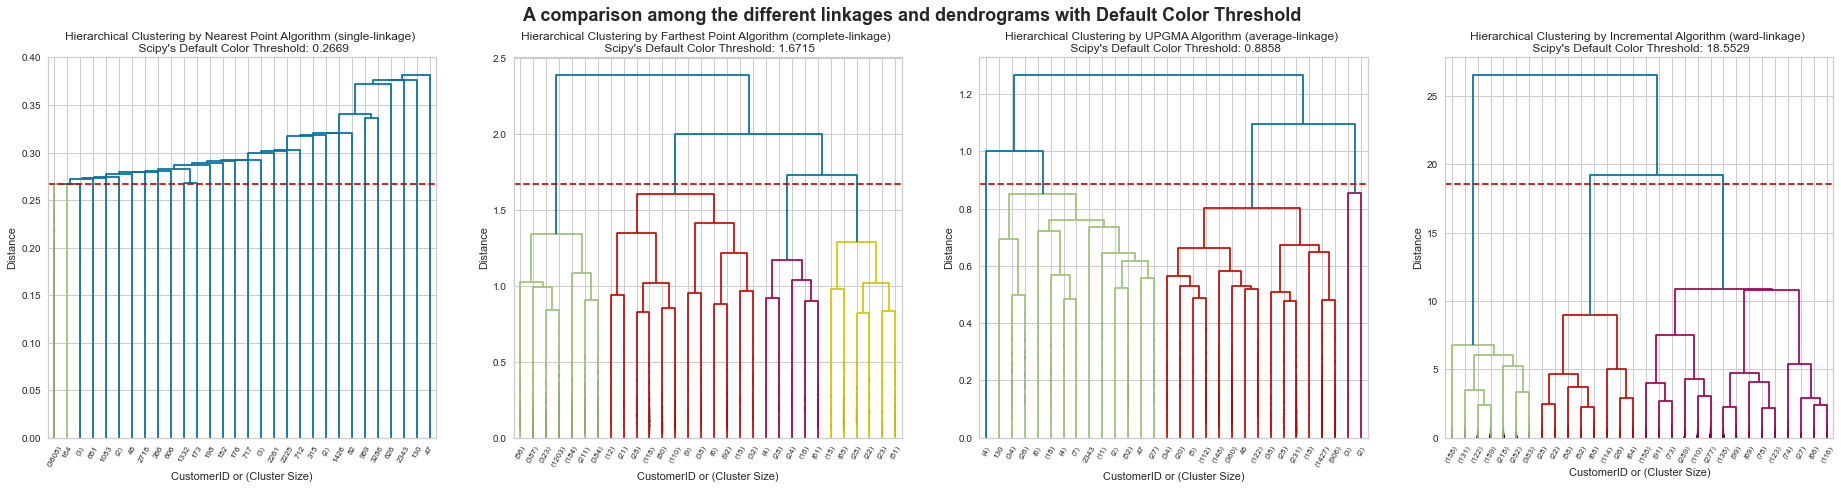

In [83]:
# We plot the four dendrograms
algorithms = ['Nearest Point', 'Farthest Point', 'UPGMA', 'Incremental']
hierarchical_models = []

f, axs = plt.subplots(ncols=4, figsize=(32,7))

for i in range(len(methods)):
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage=methods[i]).fit(cs_norm_minmax) 
    plot_dendrogram(model, truncate_mode='lastp', p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True, ax=axs[i])
    hierarchical_models.append(model)
    
    axs[i].set_title('Hierarchical Clustering by ' + algorithms[i] + ' Algorithm (' + methods[i] + '-linkage) \n Scipy\'s Default Color Threshold: ' + '{:2.4f}'.format(defaults_color_thresholds[i]))
    axs[i].set_xlabel('CustomerID or (Cluster Size)')
    axs[i].set_ylabel('Distance')
    axs[i].axhline(defaults_color_thresholds[i], ls='--', color='r')

plt.suptitle(('A comparison among the different linkages and dendrograms with Default Color Threshold'),
             fontsize=18, fontweight='bold')
plt.show()

#### Identifying the best cut

We define a function to identify the height of the optimal cut within a dendrogram. It works by iteratively cutting the tree at an height increased at each step. Each cut returns the given number of clusters identified by the structure under the cut and, by calculating the value for the number of clusters suggested by the greater number of cuts, we can identify the longest uninterrupted vertical segment of the dendrogram. 

The function takes in input:
- the linkage-method to utilize in order to compute the proximity among the nodes
- the step to utilize to increase the height of the cuts at each iteration and 
- the data for which we want to perform the clustering.

In [84]:
def get_best_cut(linkage, step, norm_dataframe):
    store_n_clusters = []
    store_distances = []

    n_clusters = 0
    i = 0

    while n_clusters != 1:
        distance_threshold = i*step
        model = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=None, affinity='euclidean', linkage=linkage).fit(norm_dataframe)
        i = i + 1

        n_clusters = model.n_clusters_
        store_distances.append(distance_threshold)
        store_n_clusters.append(n_clusters)

    df = pd.DataFrame()

    df['distance_thresholds'] = store_distances
    df['n_clusters'] = store_n_clusters
    
    df_n_clusters_groups = df.groupby('n_clusters').size()
    
    n_for_opt_cut = df_n_clusters_groups.agg(['idxmax'])[0]
    distance = df[df.n_clusters == n_for_opt_cut].distance_thresholds.min()
    
    print('Performed analysis for ' + linkage + '-linkage: reached n_clusters = 1 in ' + str(i) + ' steps')
    #print('OPT: Dist = ' + str(distance) + ', n_clusters = ' + str(n_for_opt_cut))     
    
    return n_for_opt_cut, distance

We search for the best cut within each of the four dendrograms.

In [85]:
steps = [0.001, 0.01, 0.01, 0.1]

opt_n_clusters = []
heights = []

for i in range(len(methods)):
    n_for_opt_cut, height = get_best_cut(methods[i], steps[i], cs_norm_minmax)
    opt_n_clusters.append(n_for_opt_cut)
    heights.append(height)
    
hierarchical_distances = pd.DataFrame()
hierarchical_distances['method'] = methods
hierarchical_distances['n_clusters_for_best_cut'] = opt_n_clusters
hierarchical_distances['height'] = heights
hierarchical_distances.set_index(['method'], inplace=True)

hierarchical_distances

Performed analysis for single-linkage: reached n_clusters = 1 in 383 steps
Performed analysis for complete-linkage: reached n_clusters = 1 in 240 steps
Performed analysis for average-linkage: reached n_clusters = 1 in 128 steps
Performed analysis for ward-linkage: reached n_clusters = 1 in 267 steps


n_clusters_for_best_cut  height
method                                   
single                          5   0.341
complete                        2   2.000
average                         2   1.100
ward                            3  10.900

We plot the dendrograms again, this time highlighting the best cut identified above. 

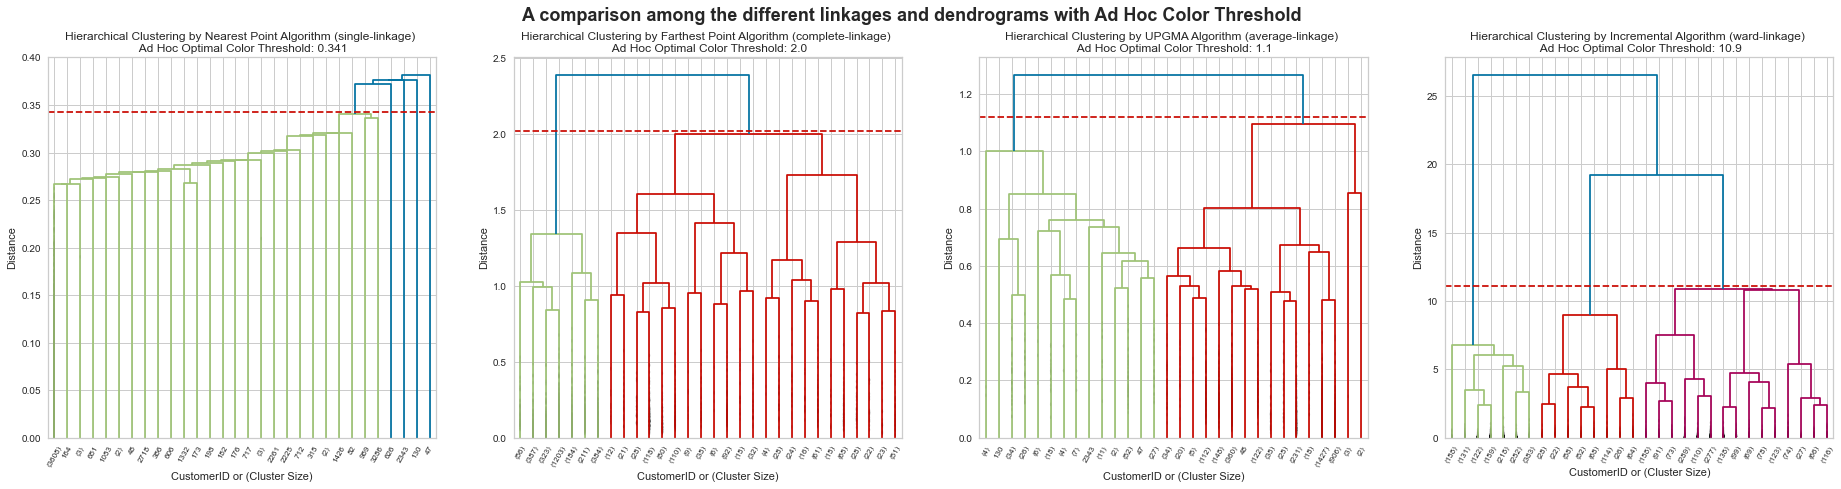

In [86]:
# We plot the four dendrograms
algorithms = ['Nearest Point', 'Farthest Point', 'UPGMA', 'Incremental']
hierarchical_models = []

f, axs = plt.subplots(ncols=4, figsize=(32,7))

for i in range(len(methods)):
    color_threshold = hierarchical_distances.loc[methods[i]].height
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage=methods[i]).fit(cs_norm_minmax) 
    plot_dendrogram(model, truncate_mode='lastp', p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True, ax=axs[i], color_threshold=color_threshold)
    hierarchical_models.append(model)
    
    axs[i].set_title('Hierarchical Clustering by ' + algorithms[i] + ' Algorithm (' + methods[i] + '-linkage) \n Ad Hoc Optimal Color Threshold: ' + str(color_threshold))
    axs[i].set_xlabel('CustomerID or (Cluster Size)')
    axs[i].set_ylabel('Distance')
    axs[i].axhline(color_threshold + steps[i]*2, ls='--', color='r')

plt.suptitle(('A comparison among the different linkages and dendrograms with Ad Hoc Color Threshold'),
             fontsize=18, fontweight='bold')
plt.show()

We compute and store the labels associated with each cut.

In [87]:
for i in range(len(methods)):
    opt_n_clusters = int(hierarchical_distances.loc[methods[i]].n_clusters_for_best_cut)
    labels = AgglomerativeClustering(n_clusters=opt_n_clusters, affinity='euclidean', linkage=methods[i]).fit_predict(cs_norm_minmax)
    cs_clusters[methods[i]] = labels

cs_clusters[['single', 'complete', 'average', 'ward']]

single  complete  average  ward
CustomerID                                 
13047.0          0         0        0     2
14688.0          0         0        1     2
17809.0          0         1        0     0
16098.0          0         1        0     0
18074.0          0         1        0     1
...            ...       ...      ...   ...
13436.0          0         1        0     1
15520.0          0         1        0     0
13298.0          0         1        0     1
14569.0          0         1        0     1
12713.0          0         0        0     0

[3643 rows x 4 columns]

We compare the four clusterings by visualizing the distribution of the points among their clusters.

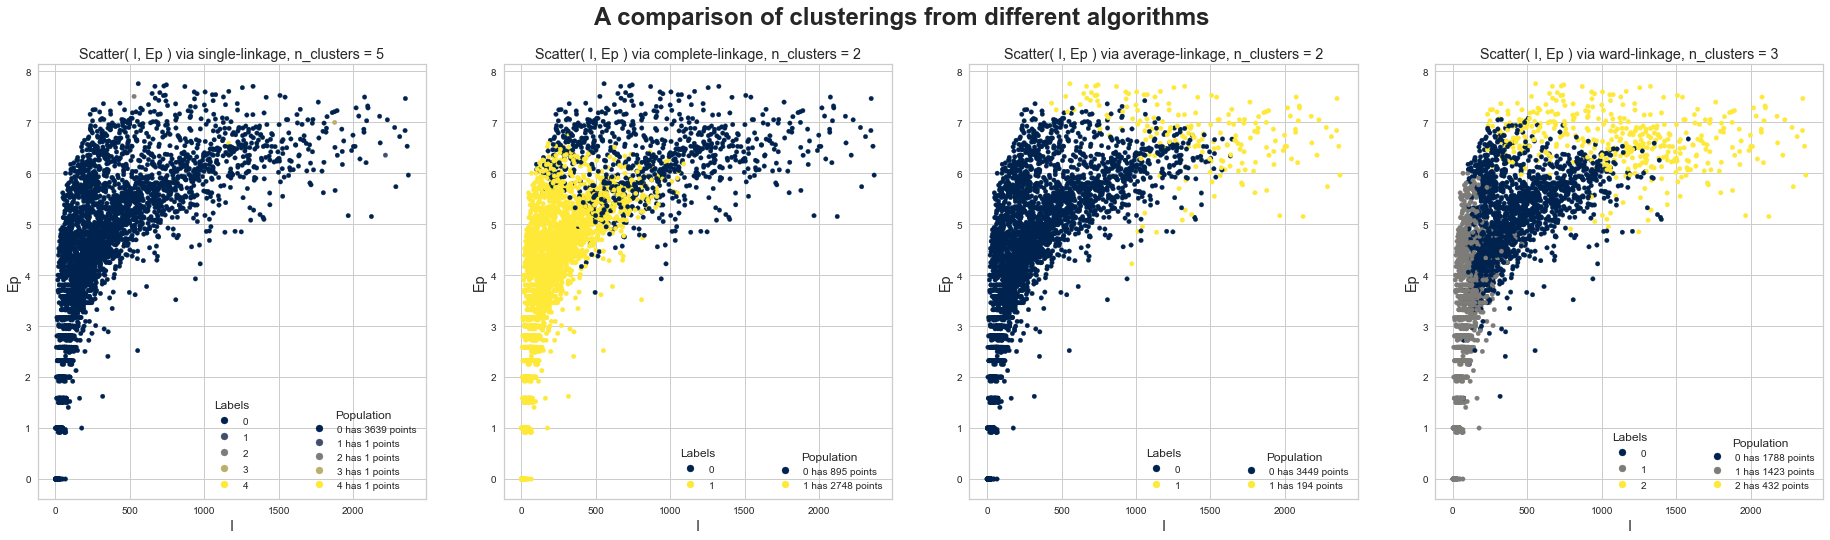

In [88]:
f, axs = plt.subplots(nrows=1, ncols=4, figsize=(32,8))
a, b = 'I', 'Ep'

for i in range(len(methods)):
    labels = cs_clusters[methods[i]]
    opt_n_clusters = int(hierarchical_distances.loc[methods[i]].n_clusters_for_best_cut)
    scatter = axs[i].scatter(cs[a], cs[b], c=labels, s=20, cmap='cividis')
    axs[i].set_title('Scatter( I, Ep ) via ' + methods[i] + '-linkage, n_clusters = ' + str(opt_n_clusters), fontdict={'fontsize': 'large'})
    axs[i].set_xlabel(a, fontdict={'fontsize': 'large'})
    axs[i].set_ylabel(b, fontdict={'fontsize': 'large'})
    
    # produce a legend with the unique colors from the scatter
    dbs_population = np.unique(labels, return_counts=True)

    legend1 = axs[i].legend(*scatter.legend_elements(), #legend_elements creates legend handles and labels for a PathCollection.
                        loc="lower center", title="Labels")
    
    axs[i].add_artist(legend1)

    # produce a legend 
    secondlegend = []
    classes = np.unique(labels).shape[0]

    for j in range(classes):
        secondlegend.append("{} has {} points".format(j, dbs_population[1][j]))
    handles = scatter.legend_elements()[0]
    labels_2 = secondlegend
    legend2 = axs[i].legend(handles, labels_2, loc="lower right", title="Population")

plt.suptitle(('A comparison of clusterings from different algorithms'),
             fontsize=24, fontweight='bold')
    
plt.show()

### Clustering Evaluation

#### Evaluation via Internal Metrics

In [89]:
int_metrics_H=pd.DataFrame() # we create a dataframe to contain the results of the evaluation
    
sep=[]
sil=[]
cal_har=[]

for method in methods:
    sep.append(davies_bouldin_score(cs_norm_minmax, cs_clusters[method]))
    sil.append(silhouette_score(cs_norm_minmax, cs_clusters[method]))
    cal_har.append(calinski_harabasz_score(cs_norm_minmax, cs_clusters[method]))

int_metrics_H['Linkage'] = methods
int_metrics_H['Davies_Bouldini'] = sep
int_metrics_H['Silhouette'] = sil
int_metrics_H['Calinski_Harabasz'] = cal_har
int_metrics_H.set_index(['Linkage'], inplace=True)
int_metrics_H

Davies_Bouldini  Silhouette  Calinski_Harabasz
Linkage                                                 
single           0.382891    0.381495           5.938170
complete         1.078697    0.426685        2421.001945
average          0.847240    0.493721        1016.287862
ward             1.157258    0.270928        2011.862144

#### Evaluation via Cophenetic Correlation Coefficient

In [90]:
cophenetic_coefficients = []

for method in methods:
    Z = linkage(cs_norm_minmax, method)
    cophenetic_coefficients = np.append(cophenetic_coefficients, np.corrcoef(pdist(cs_norm_minmax), cophenet(Z))[0][1])

In [91]:
hierarchical_eval = pd.DataFrame()
hierarchical_eval['method'] = methods
hierarchical_eval['cophenetic_corr'] = cophenetic_coefficients
hierarchical_eval.set_index(['method'], inplace=True)
hierarchical_eval

cophenetic_corr
method                   
single           0.738448
complete         0.707183
average          0.771549
ward             0.472974

## Comparison of the clusterings


In [92]:
relative_evaluation = pd.DataFrame()

clustering_a = ['K_2', 'K_2', 'K_3', 'K_4']
clustering_b = ['complete', 'average', 'ward', 'DBSCAN']
store_homogeneity = []
store_completeness = []
store_v_measure = []
for i in range(len(clustering_a)):
    homogeneity, completeness, v_measure = metrics.homogeneity_completeness_v_measure(cs_clusters[clustering_a[i]], cs_clusters[clustering_b[i]])
    store_homogeneity.append(homogeneity)
    store_completeness.append(completeness)
    store_v_measure.append(v_measure)

relative_evaluation['clustering_a'] = clustering_a
relative_evaluation['clustering_b'] = clustering_b
relative_evaluation['homogeneity'] = store_homogeneity
relative_evaluation['completeness'] = store_completeness
relative_evaluation['v_measure'] = store_v_measure

relative_evaluation.set_index(['clustering_a', 'clustering_b'], inplace=True)
relative_evaluation

homogeneity  completeness  v_measure
clustering_a clustering_b                                      
K_2          complete         0.463783      0.521327   0.490874
             average          0.102075      0.307581   0.153282
K_3          ward             0.500030      0.532198   0.515613
K_4          DBSCAN           0.230773      0.425317   0.299202

### Visual comparison for clusterings with 2 clusters

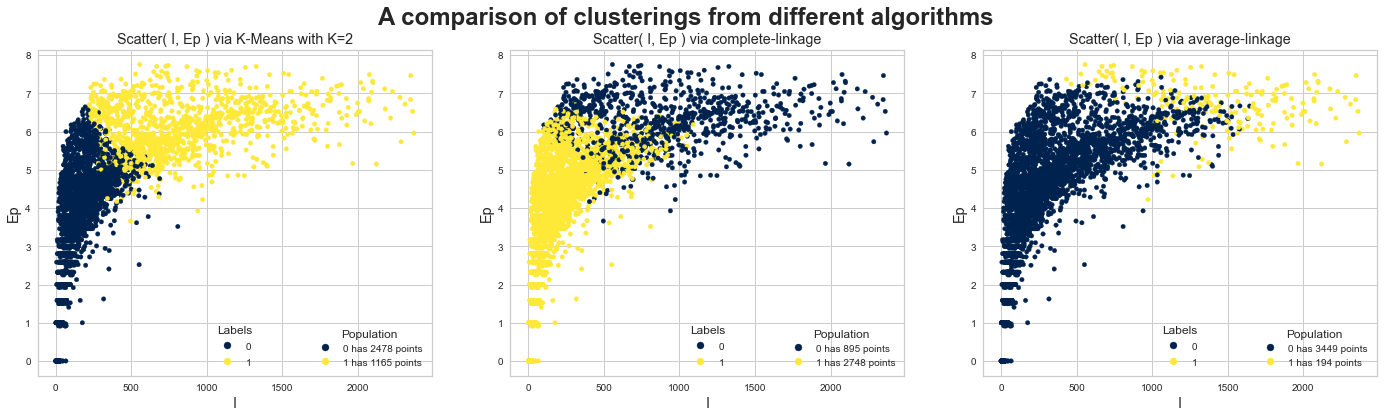

In [93]:
f, axs = plt.subplots(nrows=1, ncols=3, figsize=(24,6))
a, b = 'I', 'Ep'
labels_set = ['K_2', 'complete', 'average']
title_set = ['K-Means with K=2', 'complete-linkage', 'average-linkage']

for i in range(3):
    labels = cs_clusters[labels_set[i]]
    scatter = axs[i].scatter(cs[a], cs[b], c=labels, s=20, cmap='cividis')
    axs[i].set_title('Scatter( I, Ep ) via ' + title_set[i], fontdict={'fontsize': 'large'})
    axs[i].set_xlabel(a, fontdict={'fontsize': 'large'})
    axs[i].set_ylabel(b, fontdict={'fontsize': 'large'})
    
    # produce a legend with the unique colors from the scatter
    dbs_population = np.unique(labels, return_counts=True)

    legend1 = axs[i].legend(*scatter.legend_elements(), #legend_elements creates legend handles and labels for a PathCollection.
                        loc="lower center", title="Labels")
    
    axs[i].add_artist(legend1)

    # produce a legend 
    secondlegend = []
    classes = np.unique(labels).shape[0]

    for j in range(classes):
        secondlegend.append("{} has {} points".format(j, dbs_population[1][j]))
    handles = scatter.legend_elements()[0]
    labels_2 = secondlegend
    legend2 = axs[i].legend(handles, labels_2, loc="lower right", title="Population")

plt.suptitle(('A comparison of clusterings from different algorithms'),
             fontsize=24, fontweight='bold')
    
plt.show()

### Visual comparison for clusterings with 3 clusters

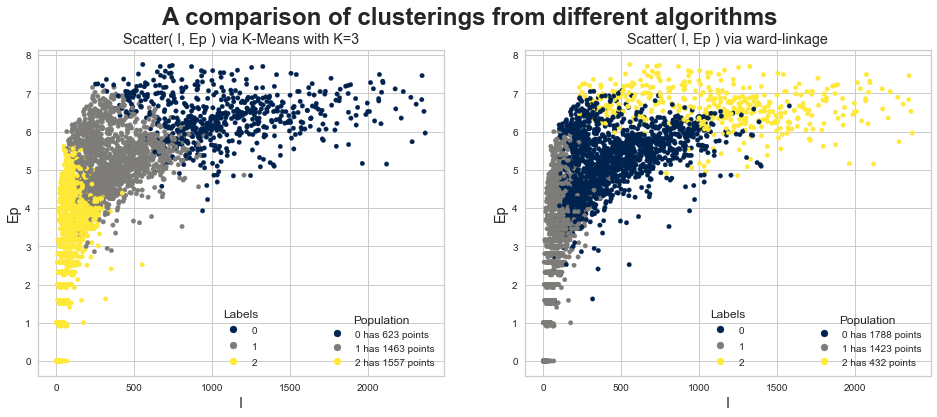

In [94]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
a, b = 'I', 'Ep'
labels_set = ['K_3', 'ward']
title_set = ['K-Means with K=3', 'ward-linkage']

for i in range(2):
    labels = cs_clusters[labels_set[i]]
    scatter = axs[i].scatter(cs[a], cs[b], c=labels, s=20, cmap='cividis')
    axs[i].set_title('Scatter( I, Ep ) via ' + title_set[i], fontdict={'fontsize': 'large'})
    axs[i].set_xlabel(a, fontdict={'fontsize': 'large'})
    axs[i].set_ylabel(b, fontdict={'fontsize': 'large'})
    
    # produce a legend with the unique colors from the scatter
    dbs_population = np.unique(labels, return_counts=True)

    legend1 = axs[i].legend(*scatter.legend_elements(), #legend_elements creates legend handles and labels for a PathCollection.
                        loc="lower center", title="Labels")
    
    axs[i].add_artist(legend1)

    # produce a legend 
    secondlegend = []
    classes = np.unique(labels).shape[0]

    for j in range(classes):
        secondlegend.append("{} has {} points".format(j, dbs_population[1][j]))
    handles = scatter.legend_elements()[0]
    labels_2 = secondlegend
    legend2 = axs[i].legend(handles, labels_2, loc="lower right", title="Population")

plt.suptitle(('A comparison of clusterings from different algorithms'),
             fontsize=24, fontweight='bold')
    
plt.show()

### Visual comparison for clusterings with 4 clusters

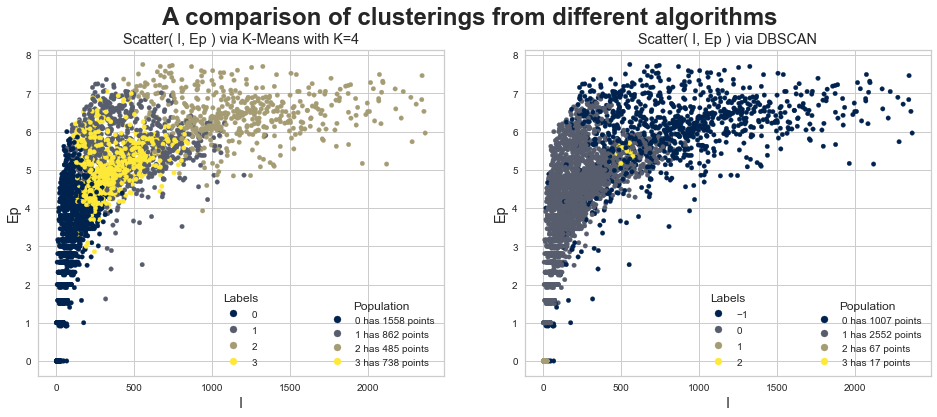

In [95]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
a, b = 'I', 'Ep'
labels_set = ['K_4', 'DBSCAN']
title_set = ['K-Means with K=4', 'DBSCAN']

for i in range(2):
    labels = cs_clusters[labels_set[i]]
    scatter = axs[i].scatter(cs[a], cs[b], c=labels, s=20, cmap='cividis')
    axs[i].set_title('Scatter( I, Ep ) via ' + title_set[i], fontdict={'fontsize': 'large'})
    axs[i].set_xlabel(a, fontdict={'fontsize': 'large'})
    axs[i].set_ylabel(b, fontdict={'fontsize': 'large'})
    
    # produce a legend with the unique colors from the scatter
    dbs_population = np.unique(labels, return_counts=True)

    legend1 = axs[i].legend(*scatter.legend_elements(), #legend_elements creates legend handles and labels for a PathCollection.
                        loc="lower center", title="Labels")
    
    axs[i].add_artist(legend1)

    # produce a legend 
    secondlegend = []
    classes = np.unique(labels).shape[0]

    for j in range(classes):
        secondlegend.append("{} has {} points".format(j, dbs_population[1][j]))
    handles = scatter.legend_elements()[0]
    labels_2 = secondlegend
    legend2 = axs[i].legend(handles, labels_2, loc="lower right", title="Population")

plt.suptitle(('A comparison of clusterings from different algorithms'),
             fontsize=24, fontweight='bold')
    
plt.show()

## Identifying the best clustering

In [96]:
int_metrics_tot = int_metrics_K
int_metrics_tot.drop(columns=['SSE'], inplace=True)
int_metrics_tot = int_metrics_tot.append(int_metrics_H)
int_metrics_tot

Davies_Bouldini  Silhouette  Calinski_Harabasz
K_2              1.002153    0.435007        3021.802248
K_3              1.160057    0.315443        2505.103841
K_4              1.192858    0.321506        2172.847202
K_5              1.147942    0.272066        2041.370447
K_7              1.183484    0.270354        1811.916029
K_8              1.127170    0.257634        1743.472511
single           0.382891    0.381495           5.938170
complete         1.078697    0.426685        2421.001945
average          0.847240    0.493721        1016.287862
ward             1.157258    0.270928        2011.862144

# Alternative clustering techniques

Now we explore alternative algorithms for data clustering, available in the *pyclustering* open source library. In particular, we have chosen from this library the Python implementations of CURE adn OPTICS algorithms.

- **Source:** https://github.com/annoviko/pyclustering/
- **Documentation:** https://pyclustering.github.io/docs/0.10.1/html/index.html

##  Data custering by CURE algorithm

**CURE(Clustering Using REpresentatives)**

- It is a hierarchical based clustering technique, that adopts a middle ground between the centroid based and  the all-point extremes. Hierarchical clustering is a type of clustering, that starts with a single point cluster, and moves to merge with another cluster, until the desired number of clusters are formed.
- It is used for identifying the spherical and non-spherical clusters.
- It is useful for discovering groups and identifying interesting distributions in the underlying data.
- Instead of using one point centroid, as in most of data mining algorithms, CURE uses a set of well-defined representative points, for efficiently handling the clusters and eliminating the outliers.

### How CURE algorithm works
To avoid the problems with non-uniform sized or shaped clusters, CURE employs a hierarchical clustering algorithm that adopts a middle ground between the centroid based and all point extremes. In CURE, a constant number c of well scattered points of a cluster are chosen and they are shrunk towards the centroid of the cluster by a fraction α. The scattered points after shrinking are used as representatives of the cluster. The clusters with the closest pair of representatives are the clusters that are merged at each step of CURE's hierarchical clustering algorithm. This enables CURE to correctly identify the clusters.

### Pros
- Compared with K-means clustering CURE is more robust (and so less sensitive) to outliers: these are detected and eliminated.
- Particularly suitable for huge amount of data: it can have a good execution time in presence of large database using random sampling and partitioning methods.
- CURE can detect cluster with non-spherical shape and wide variance in size using a set of representative points for each cluster.
- As opposed to the DBSCAN algorithm, varying densities of the data points doesn’t matter in CURE clustering algorithm.


In [99]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster import cluster_visualizer_multidim
from pyclustering.cluster.cure import cure

In [100]:
# Array conversion to a list
cs_norm_minmax_list = cs_norm_minmax.tolist()
# Input data in following format [ [0.1, 0.5], [0.3, 0.1], ... ].
input_data = cs_norm_minmax_list

In [101]:
# Allocate three clusters.
cure_instance = cure(input_data, 3)
cure_instance.process() # Performs cluster analysis in line with rules of CURE algorithm.
clusters = cure_instance.get_clusters() # Returns list of allocated clusters, each cluster contains indexes of objects in list of data.

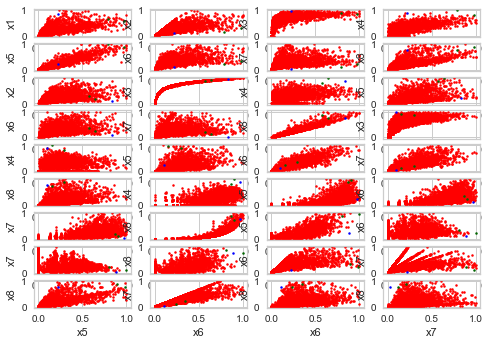

In [102]:
# Visualize allocated clusters
visualizer = cluster_visualizer_multidim()
visualizer.append_clusters(clusters, input_data)
visualizer.show(visible_axis=True, row_size=30)

The results provided by the CURE algorithm seems rather surprising. It's supposed resistence against the presence of outliers and varying densities doesn't seem to resemble the almost unique cluster identified.
Such conclusions seems to agree with the well-known variance in performance that tends to relate to the inherent sintony of each algorithm to a particular dataset.

## Data custering by OPTICS algorithm
It is a new algorithm for the purpose of cluster analysis which does not produce a clustering of a data set explicitly; but instead creates an augmented ordering of the database representing its density-based clustering structure. This cluster-ordering contains information which is equivalent to the density-based clusterings corresponding to a broad range of parameter settings. It is a versatile basis for both automatic and interactive cluster analysis. 

- **Source**: Mihael Ankerst, Markus M. Breunig, Hans-Peter Kriegel, Jörg Sander, *OPTICS: ordering points to identify the clustering structure*, 1999, DOI: https://doi.org/10.1145/304182.304187.

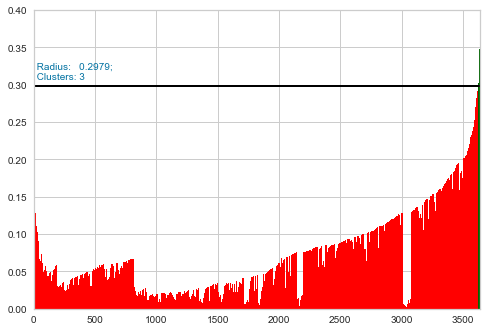

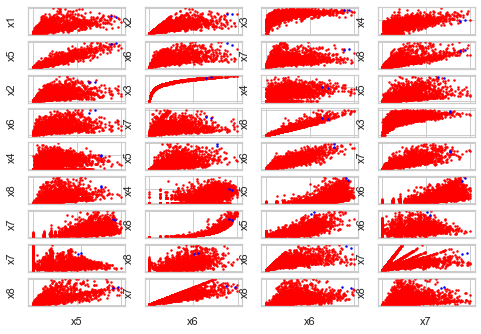

In [103]:
from pyclustering.cluster.optics import optics, ordering_analyser, ordering_visualizer

# Read sample for clustering from some file
sample = cs_norm_minmax_list

# Run cluster analysis where connectivity radius is bigger than real
radius = 2.0
neighbors = 3
amount_of_clusters = 3
optics_instance = optics(sample, radius, neighbors, amount_of_clusters)

# Performs cluster analysis
optics_instance.process()

# Obtain results of clustering
clusters = optics_instance.get_clusters()
noise = optics_instance.get_noise()
ordering = optics_instance.get_ordering()

# Visualize ordering diagram
analyser = ordering_analyser(ordering)
ordering_visualizer.show_ordering_diagram(analyser, amount_of_clusters)

# Visualize clustering results
visualizer = cluster_visualizer_multidim()
visualizer.append_clusters(clusters, sample)
visualizer.show()

The results provided by OPTICS, being a density-based algorithm, seems to have been influenced by the density of the points from the dataset. 

## Fuzzy C-means

Since we had the opportunity to study and explore the fuzzy-logic approach during the SmartApp course of professor Gervasi, we were very curious to try this algorithm.

Fuzzy clustering is a form of clustering in which each data point can belong to more than one cluster.

Among the possible purposis of this approach there is even image segmentation.

### How the algorithm works
Fuzzy C-Means algorithm uses two general formulas for cluster analysis. 
- The first is to updated membership of each point:

$w_{ij}=\frac{1}{\sum_{k=0}^{c}\left ( \frac{\left \| x_{i}-c_{j} \right \|}{\left \| x_{i}-c_{k} \right \|} \right )^{\frac{2}{m-1}}}$

- The second formula is used to update centers in line with obtained centers:

$c_{k}=\frac{\sum_{i=0}^{N}w_{k}\left ( x_{i} \right )^{m}x_{i}}{\sum_{i=0}^{N}w_{k}\left ( x_{i} \right )^{m}}$

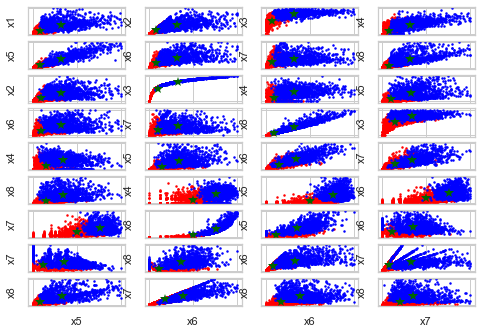

In [104]:
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.fcm import fcm
 
# load list of points for cluster analysis
sample = cs_norm_minmax_list
 
# initialize
initial_centers = kmeans_plusplus_initializer(sample, 2, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()
 
# create instance of Fuzzy C-Means algorithm
fcm_instance = fcm(sample, initial_centers)
 
# run cluster analysis and obtain results
fcm_instance.process()
clusters = fcm_instance.get_clusters()
centers = fcm_instance.get_centers()
 
# visualize clustering results
visualizer = cluster_visualizer_multidim()
visualizer.append_clusters(clusters, sample)
visualizer.append_cluster(centers, marker='*', markersize=10)
visualizer.show()

Fuzzy C-means, being a centroid based algorithm, provides results similar to those provided by K-means. The main difference is the unbalance between the dimensions of the two clusters based upon the majority of the customers being concentrated within the second one.  